# Test case A: Sequential OED

In [49]:
import numpy as np
from jax import jit, vjp, vmap
import jax
from jax import numpy as jnp
from jax import random
from matplotlib import pyplot as plt


from jwave.geometry import Domain, Medium
from jwave.utils import display_complex_field

key = random.PRNGKey(42)  # Random seed


from hybridoed.forward import create_src_field
from hybridoed.oed import *

In [ ]:
from jwave.acoustics.time_harmonic import helmholtz, helmholtz_solver

def solve_helmholtz_general(sound_speed, src_coord, omega):
    # Ensure src_coord is at least 1D
    src_coord = jnp.atleast_1d(src_coord)
    # print("src_coord:", src_coord, "shape:", src_coord.shape)

    x, y = src_coord[0], src_coord[1]
    src = create_src_field(N, x, y, domain, omega)
    medium = Medium(domain=domain, sound_speed=sound_speed, density=1000., pml_size=10)
    field = helmholtz_solver(medium, omega, src)
    return field.on_grid.squeeze()




In [62]:
def extract_receiver_values_interpolated(field, receiver_coords):
    # Assume receiver_coords is a float array
    x_floor = jnp.floor(receiver_coords[:, 0]).astype(jnp.int32)
    y_floor = jnp.floor(receiver_coords[:, 1]).astype(jnp.int32)
    x_ceil = jnp.ceil(receiver_coords[:, 0]).astype(jnp.int32)
    y_ceil = jnp.ceil(receiver_coords[:, 1]).astype(jnp.int32)

    # Interpolation weights
    wx = receiver_coords[:, 0] - x_floor
    wy = receiver_coords[:, 1] - y_floor

    # Bilinear interpolation
    top_left = field[x_floor, y_floor]
    top_right = field[x_floor, y_ceil]
    bottom_left = field[x_ceil, y_floor]
    bottom_right = field[x_ceil, y_ceil]

    interpolated_values = (
        (1 - wx) * (1 - wy) * top_left +
        wx * (1 - wy) * top_right +
        (1 - wx) * wy * bottom_left +
        wx * wy * bottom_right
    )

    # Return real and imaginary parts separately
    return jnp.real(interpolated_values), jnp.imag(interpolated_values)

def compute_jacobian_at_receivers_vjp(sound_speed, src_coords, omega, receiver_coords):
    def field_at_receivers(sound_speed, src_coord, receiver_coords, omega):
        field = solve_helmholtz_general(sound_speed, src_coord, omega)
        rec_real, rec_imag = extract_receiver_values_interpolated(field, receiver_coords)
        return rec_real, rec_imag
    
    jacobians_real = []
    jacobians_imag = []
    
    for src_coord in src_coords:
        # Compute VJP for the given source
        (y_real, y_imag), vjp_fn = vjp(lambda s: field_at_receivers(s, src_coord,receiver_coords, omega), sound_speed)
        
        # Calculate VJP for both real and imaginary parts
        jacobian_real = vjp_fn((jnp.ones_like(y_real), jnp.zeros_like(y_imag)))[0]
        jacobian_imag = vjp_fn((jnp.zeros_like(y_real), jnp.ones_like(y_imag)))[0]
        
        jacobians_real.append(jacobian_real)
        jacobians_imag.append(jacobian_imag)
    
    # Stack the Jacobians for each source
    return jnp.array(jacobians_real), jnp.array(jacobians_imag)

In [63]:
N = (70, 70)  # Grid size
# dx = (0.1, 0.1)  # Spatial resolution
dx = (1.0, 1.0)  # Spatial resolution
f = 400
omega = 2*jnp.pi*f  # Wavefield omega = 2*pi*f

# Defining the domain
domain = Domain(N, dx)

In [64]:
def compute_and_store_jacobians(sound_speed, frequencies, src_coords_list, receiver_coords_list):
    n_sources = len(src_coords_list)
    n_receivers = len(receiver_coords_list)
    n_frequencies = len(frequencies)

    # Preallocate storage for Jacobians
    jacobian_shape = (n_sources, n_receivers, n_frequencies, 70, 140)  # Assuming the Jacobian is 70x140
    jacobians = jnp.zeros(jacobian_shape)

    for f_idx, f in enumerate(frequencies):
        omega = 2 * jnp.pi * f

        for s_idx, src_coords in enumerate(src_coords_list):
            for r_idx, receiver_coords in enumerate(receiver_coords_list):
                # Compute Jacobian for the specific triplet
                jacobian_real, jacobian_imag = compute_jacobian_at_receivers_vjp(
                    sound_speed, src_coords, omega, receiver_coords[None, :]
                )

                # Combine real and imaginary parts into a single 2D matrix
                jacobian_2d = jnp.hstack((
                    jacobian_real.reshape(-1, jacobian_real.shape[-1]),
                    jacobian_imag.reshape(-1, jacobian_imag.shape[-1])
                ))

                # Store in the preallocated array
                jacobians = jacobians.at[s_idx, r_idx, f_idx, :, :].set(jacobian_2d)

    return jacobians



In [65]:
frequencies = [100, 200, 400]  # List of frequencies

src_coords_list = [
    jnp.array([[8.1, 16.1]]).astype(jnp.float32),
    jnp.array([[12.1, 24.1]]).astype(jnp.float32),
]  

receiver_coords_list = jnp.array([
    [8.1, 0.125 * N[1] + 0.1],
    [8.1, 0.25 * N[1] + 0.1],
    [8.1, 0.5 * N[1] + 0.1],
    [8.1, 0.75 * N[1] + 0.1],
    [8.1, 0.9 * N[1] + 0.1],
]).astype(jnp.float32)

sound_speed = jnp.ones(N) * 1500  # Example sound speed model

In [66]:


jacobians = compute_and_store_jacobians(
    sound_speed, frequencies, src_coords_list, receiver_coords_list
)
print("Jacobian array shape:", jacobians.shape)

src_coord: [ 8.1 16.1] shape: (2,)
src_coord: [ 8.1 16.1] shape: (2,)
src_coord: [ 8.1 16.1] shape: (2,)
src_coord: [ 8.1 16.1] shape: (2,)
src_coord: [ 8.1 16.1] shape: (2,)
src_coord: [12.1 24.1] shape: (2,)
src_coord: [12.1 24.1] shape: (2,)
src_coord: [12.1 24.1] shape: (2,)
src_coord: [12.1 24.1] shape: (2,)
src_coord: [12.1 24.1] shape: (2,)
src_coord: [ 8.1 16.1] shape: (2,)
src_coord: [ 8.1 16.1] shape: (2,)
src_coord: [ 8.1 16.1] shape: (2,)
src_coord: [ 8.1 16.1] shape: (2,)
src_coord: [ 8.1 16.1] shape: (2,)
src_coord: [12.1 24.1] shape: (2,)
src_coord: [12.1 24.1] shape: (2,)
src_coord: [12.1 24.1] shape: (2,)
src_coord: [12.1 24.1] shape: (2,)
src_coord: [12.1 24.1] shape: (2,)
src_coord: [ 8.1 16.1] shape: (2,)
src_coord: [ 8.1 16.1] shape: (2,)
src_coord: [ 8.1 16.1] shape: (2,)
src_coord: [ 8.1 16.1] shape: (2,)
src_coord: [ 8.1 16.1] shape: (2,)
src_coord: [12.1 24.1] shape: (2,)
src_coord: [12.1 24.1] shape: (2,)
src_coord: [12.1 24.1] shape: (2,)
src_coord: [12.1 24.

## Batched

In [53]:
def extract_receiver_values_interpolated(field, receiver_coords):
    # Assume receiver_coords is a float array with shape (n_receivers, 2)
    x_floor = jnp.floor(receiver_coords[:, 0]).astype(jnp.int32)
    y_floor = jnp.floor(receiver_coords[:, 1]).astype(jnp.int32)
    x_ceil = jnp.ceil(receiver_coords[:, 0]).astype(jnp.int32)
    y_ceil = jnp.ceil(receiver_coords[:, 1]).astype(jnp.int32)

    # Interpolation weights
    wx = receiver_coords[:, 0] - x_floor
    wy = receiver_coords[:, 1] - y_floor

    # Bilinear interpolation
    top_left = field[x_floor, y_floor]
    top_right = field[x_floor, y_ceil]
    bottom_left = field[x_ceil, y_floor]
    bottom_right = field[x_ceil, y_ceil]

    interpolated_values = (
        (1 - wx)[:, None] * (1 - wy)[:, None] * top_left +
        wx[:, None] * (1 - wy)[:, None] * top_right +
        (1 - wx)[:, None] * wy[:, None] * bottom_left +
        wx[:, None] * wy[:, None] * bottom_right
    )

    # Return real and imaginary parts separately
    return jnp.real(interpolated_values), jnp.imag(interpolated_values)


def compute_jacobian_at_receivers_vjp(sound_speed, src_coords, omega, receiver_coords):
    def field_at_receivers(sound_speed, src_coord, receiver_coords, omega):
        # Ensure receiver_coords has shape (n_receivers, 2)
        assert receiver_coords.ndim == 2 and receiver_coords.shape[1] == 2, \
            f"Invalid receiver_coords shape: {receiver_coords.shape}"
        field = solve_helmholtz_general(sound_speed, src_coord, omega)
        rec_real, rec_imag = extract_receiver_values_interpolated(field, receiver_coords)
        return rec_real, rec_imag
    
    jacobians_real = []
    jacobians_imag = []
    
    for src_coord in src_coords:
        # Compute VJP for the given source
        (y_real, y_imag), vjp_fn = vjp(lambda s: field_at_receivers(s, src_coord, receiver_coords, omega), sound_speed)
        
        # Calculate VJP for both real and imaginary parts
        jacobian_real = vjp_fn((jnp.ones_like(y_real), jnp.zeros_like(y_imag)))[0]
        jacobian_imag = vjp_fn((jnp.zeros_like(y_real), jnp.ones_like(y_imag)))[0]
        
        jacobians_real.append(jacobian_real)
        jacobians_imag.append(jacobian_imag)
    
    # Stack the Jacobians for each source
    return jnp.array(jacobians_real), jnp.array(jacobians_imag)


In [54]:
def batched_compute_jacobian(sound_speed, frequencies, src_coords_list, receiver_coords_list):
    def compute_single_jacobian(f, src_coord, receiver_coord):
        omega = 2 * jnp.pi * f
        jacobian_real, jacobian_imag = compute_jacobian_at_receivers_vjp(
            sound_speed, src_coord, omega, receiver_coord[None, :]
        )
        jacobian_2d = jnp.hstack((
            jacobian_real.reshape(-1, jacobian_real.shape[-1]),
            jacobian_imag.reshape(-1, jacobian_imag.shape[-1])
        ))
        return jacobian_2d

    # Vectorize over receivers
    compute_vmap_receivers = vmap(compute_single_jacobian, in_axes=(None, None, 0))

    # Vectorize over sources
    compute_vmap_sources = vmap(compute_vmap_receivers, in_axes=(None, 0, None))

    # Vectorize over frequencies
    compute_vmap_frequencies = vmap(compute_vmap_sources, in_axes=(0, None, None))

    # Execute batched computation
    jacobians = compute_vmap_frequencies(frequencies, src_coords_list, receiver_coords_list)
    return jacobians




In [55]:
frequencies = jnp.array([100, 200, 400])  # Shape: (n_frequencies,)
src_coords_list = jnp.array([
    [8.1, 16.1],
    [12.1, 24.1],
])  # Shape: (n_sources, 2)
receiver_coords_list = jnp.array([
    [8.1, 4.1],
    [12.1, 20.1],
    [16.1, 30.1],
])  # Shape: (n_receivers, 2)

print("src_coords_list shape:", src_coords_list.shape)


sound_speed = jnp.ones((70, 70)) * 1500  # Shape: (grid_x, grid_y)


src_coords_list shape: (2, 2)


In [56]:


# Compute batched Jacobians
jacobians = batched_compute_jacobian(
    sound_speed, frequencies, src_coords_list, receiver_coords_list
)

print("Jacobian array shape:", jacobians.shape)



src_coord: Traced<ShapedArray(float32[1])>with<BatchTrace(level=2/0)> with
  val = Array([[ 8.1],
       [12.1]], dtype=float32)
  batch_dim = 0 shape: (1,)
src_coord: Traced<ShapedArray(float32[1])>with<BatchTrace(level=2/0)> with
  val = Array([[16.1],
       [24.1]], dtype=float32)
  batch_dim = 0 shape: (1,)
Jacobian array shape: (3, 2, 3, 140, 140)


## Plots the Jacobians

In [67]:
def plot_jacobians_separately(jacobians, frequencies, src_coords, rec_coords, save_path=None):
    """
    Plot the real and imaginary parts of Jacobians separately from a structured array.
    
    Parameters:
        jacobians (array): Array of shape (n_sources, n_receivers, n_frequencies, rows, cols).
        frequencies (list): List of frequencies corresponding to the third dimension of `jacobians`.
        src_coords (list): List of source coordinates.
        rec_coords (array): Array of receiver coordinates.
        save_path (str, optional): Path to save the plots. If None, displays them instead.
    """
    n_sources, n_receivers, n_frequencies, _, _ = jacobians.shape

    for f_idx in range(n_frequencies):
        for s_idx in range(n_sources):
            for r_idx in range(n_receivers):
                # Extract real and imaginary parts
                real_part = jacobians[s_idx, r_idx, f_idx, :, :70]
                imaginary_part = jacobians[s_idx, r_idx, f_idx, :, 70:]

                # Plot real part
                plt.figure(figsize=(10, 8))
                plt.imshow(real_part, aspect='auto', cmap='viridis')
                plt.colorbar(label="Magnitude")
                title_real = (
                    f"Jacobian Real Part\n"
                    f"Frequency: {frequencies[f_idx]} Hz, "
                    f"Source: {src_coords[s_idx][0]}, "
                    f"Receiver: {rec_coords[r_idx]}"
                )
                plt.title(title_real)
                plt.xlabel("Grid Points (Flattened)")
                plt.ylabel("Receivers")
                plt.tight_layout()

                # Overlay source and receiver markers
                if src_coords is not None and rec_coords is not None:
                    plt.scatter(src_coords[s_idx][0, 1], src_coords[s_idx][0, 0], marker='*', c='red', s=100)
                    plt.scatter(rec_coords[r_idx, 1], rec_coords[r_idx, 0], marker='^', c='blue', s=100)

                # Save or show real part
                if save_path:
                    filename_real = f"{save_path}/jacobian_real_f{f_idx}_s{s_idx}_r{r_idx}.png"
                    plt.savefig(filename_real, dpi=300)
                else:
                    plt.show()

                # Plot imaginary part
                plt.figure(figsize=(10, 8))
                plt.imshow(imaginary_part, aspect='auto', cmap='viridis')
                plt.colorbar(label="Magnitude")
                title_imag = (
                    f"Jacobian Imaginary Part\n"
                    f"Frequency: {frequencies[f_idx]} Hz, "
                    f"Source: {src_coords[s_idx][0]}, "
                    f"Receiver: {rec_coords[r_idx]}"
                )
                plt.title(title_imag)
                plt.xlabel("Grid Points (Flattened)")
                plt.ylabel("Receivers")
                plt.tight_layout()

                # Overlay source and receiver markers
                if src_coords is not None and rec_coords is not None:
                    plt.scatter(src_coords[s_idx][0, 1], src_coords[s_idx][0, 0], marker='*', c='red', s=100)
                    plt.scatter(rec_coords[r_idx, 1], rec_coords[r_idx, 0], marker='^', c='blue', s=100)

                # Save or show imaginary part
                if save_path:
                    filename_imag = f"{save_path}/jacobian_imag_f{f_idx}_s{s_idx}_r{r_idx}.png"
                    plt.savefig(filename_imag, dpi=300)
                else:
                    plt.show()


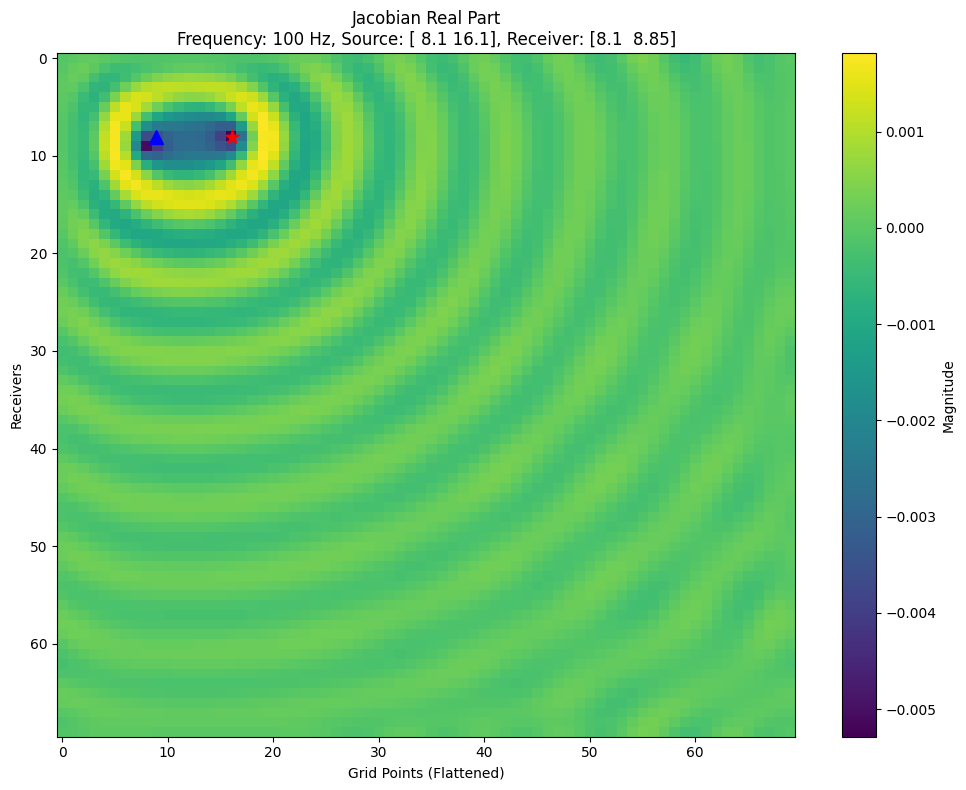

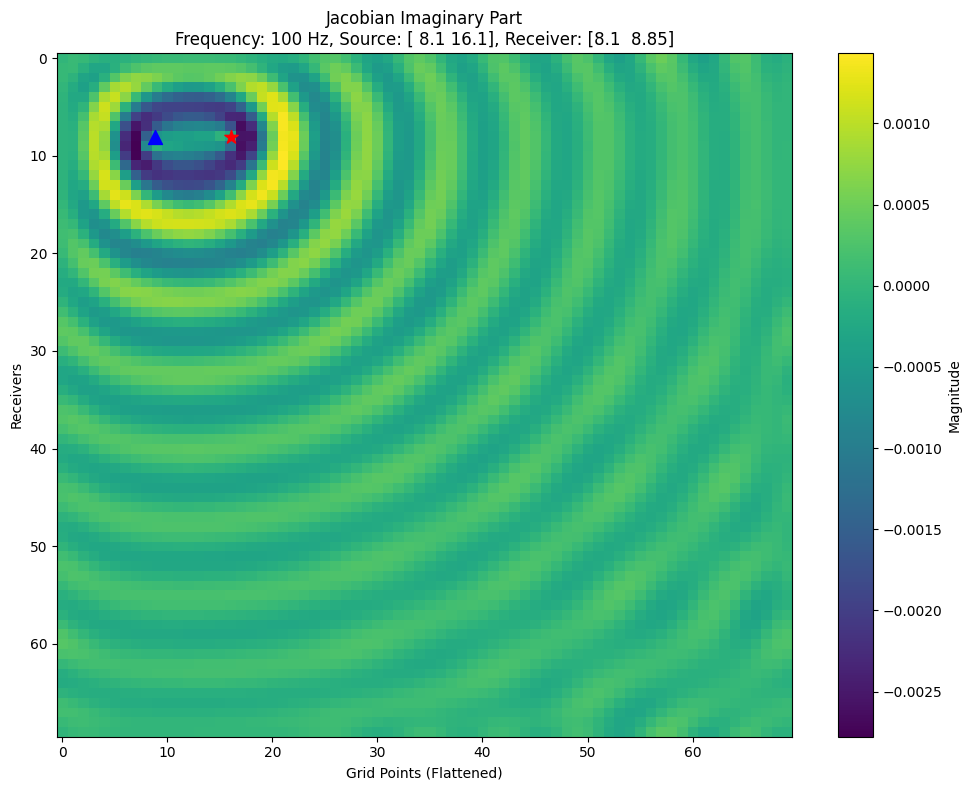

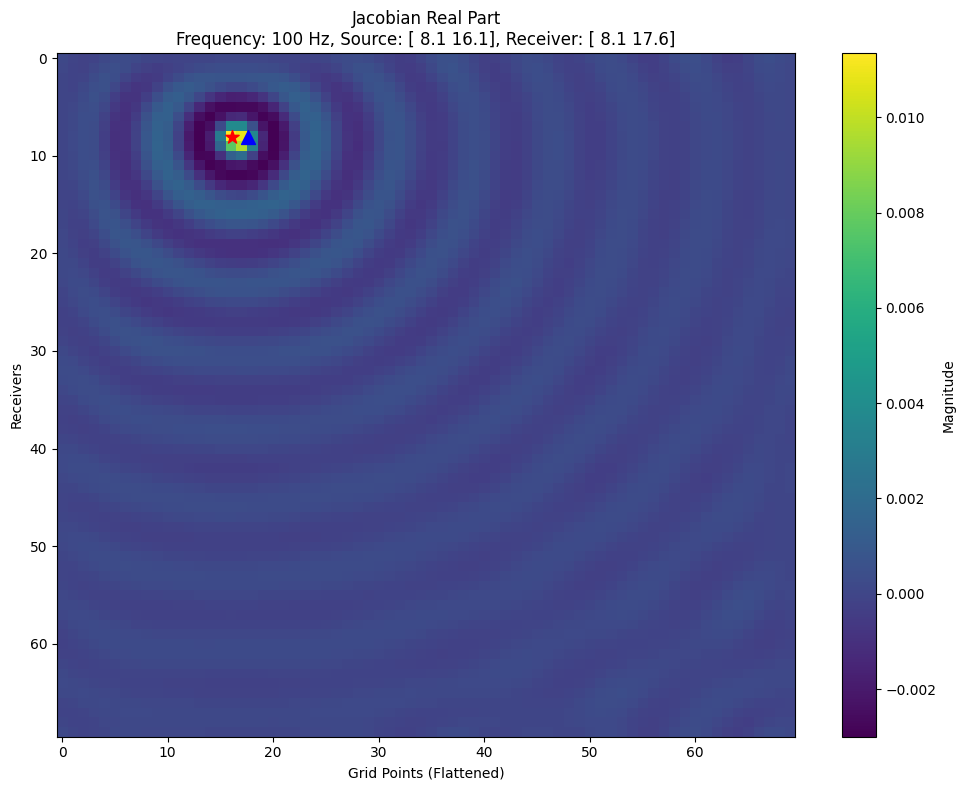

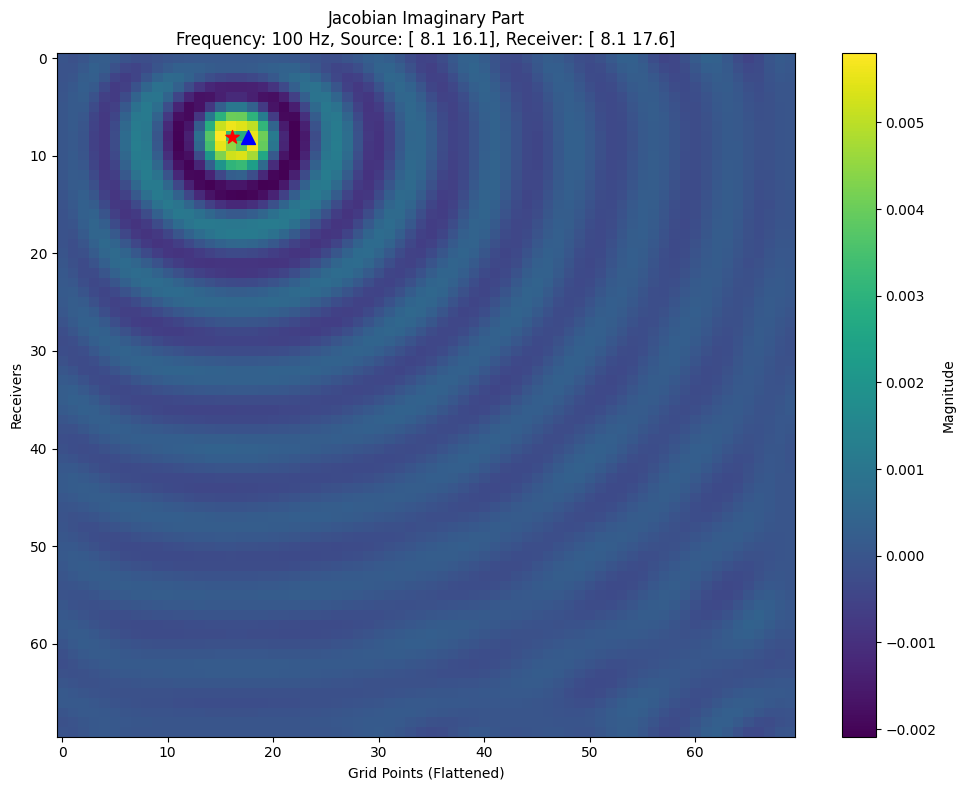

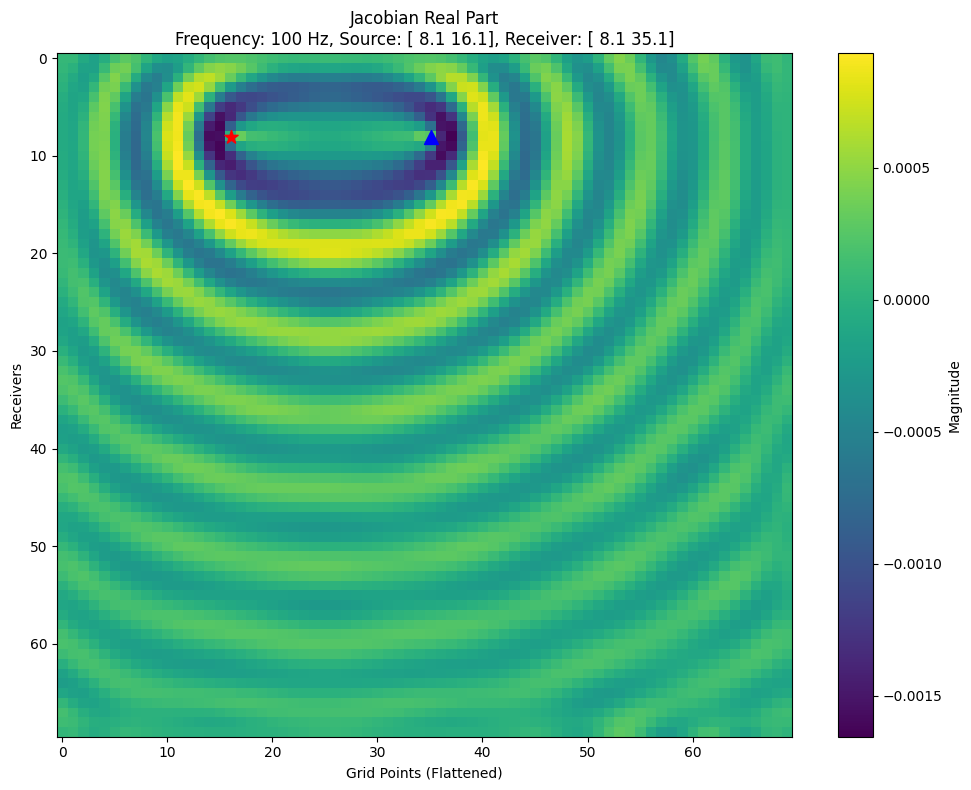

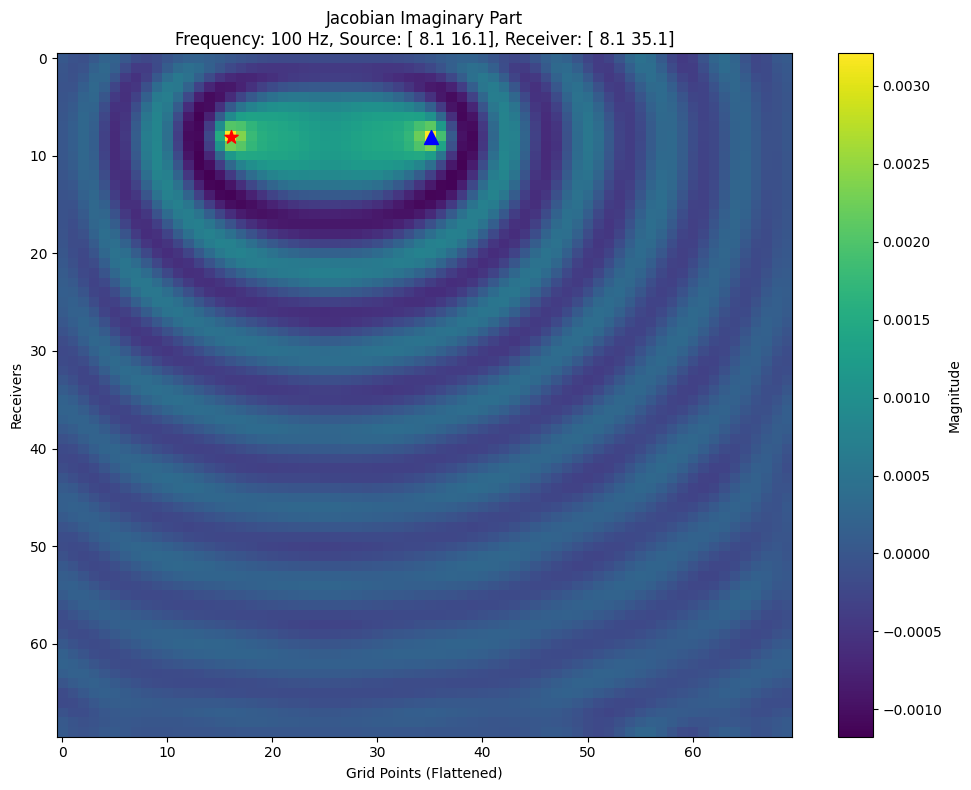

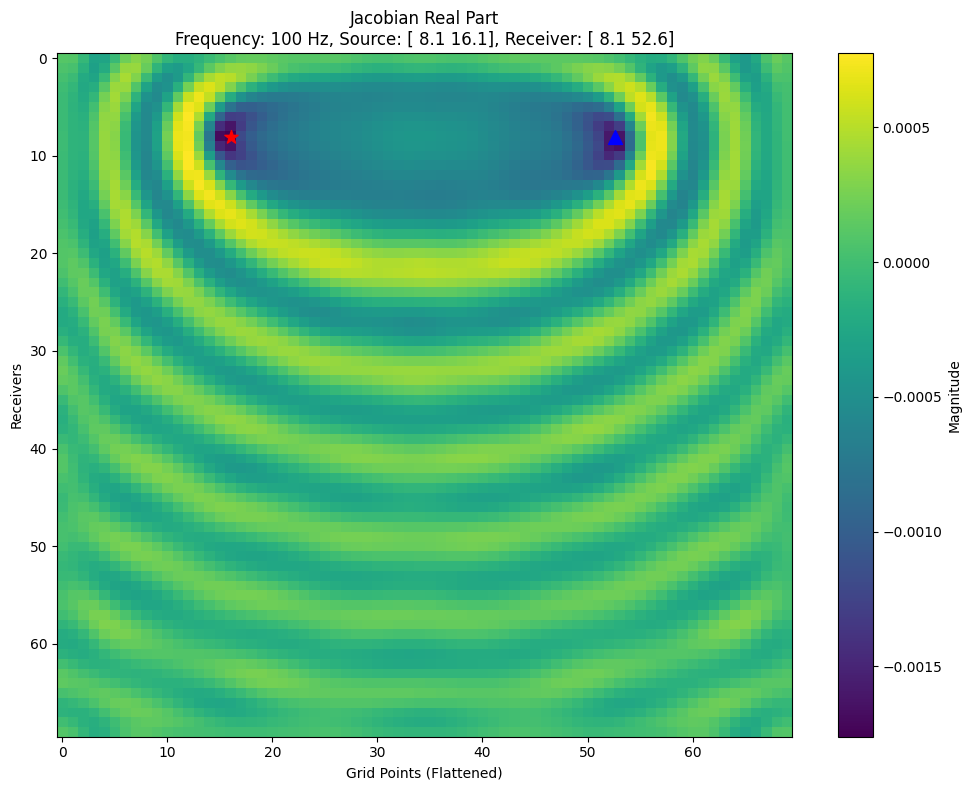

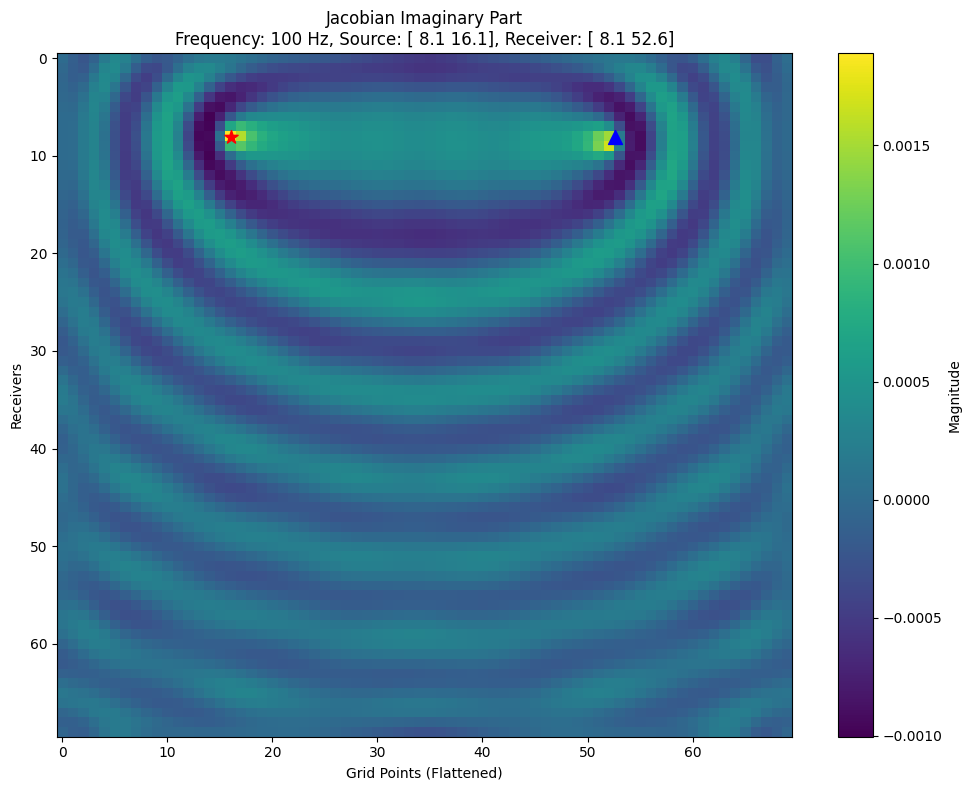

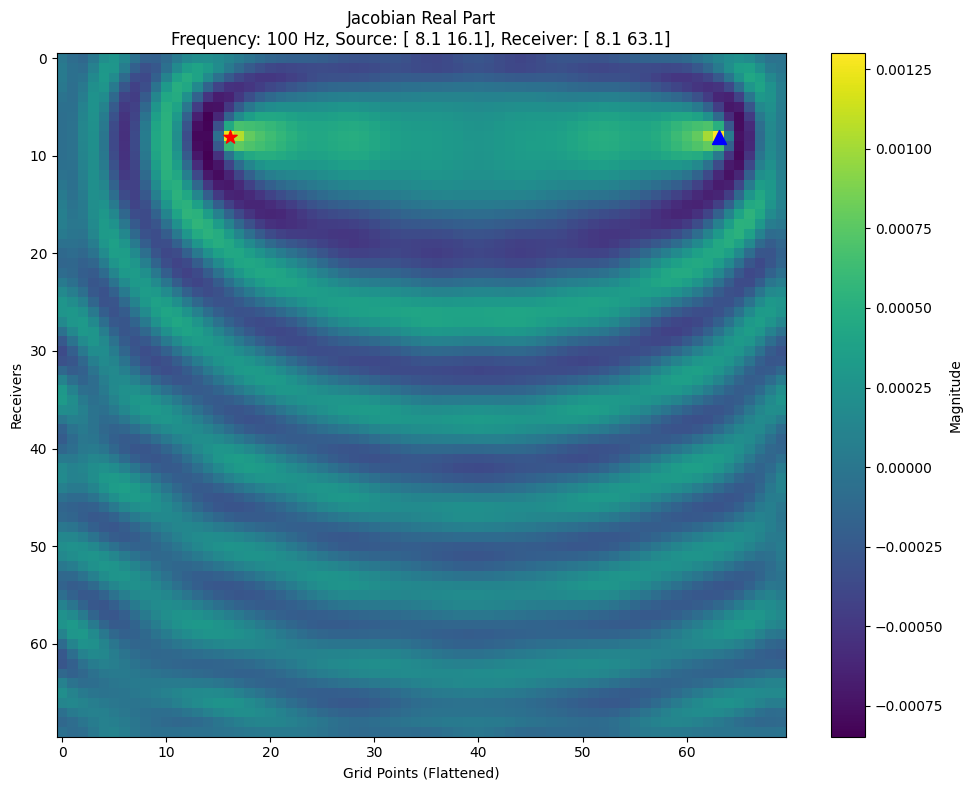

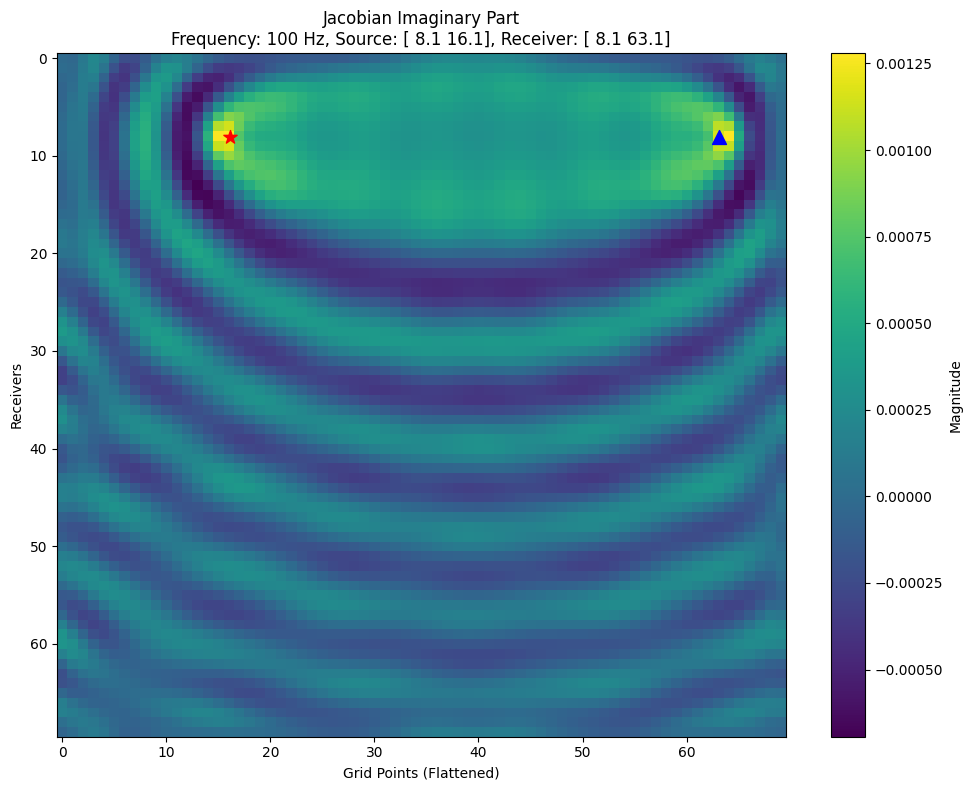

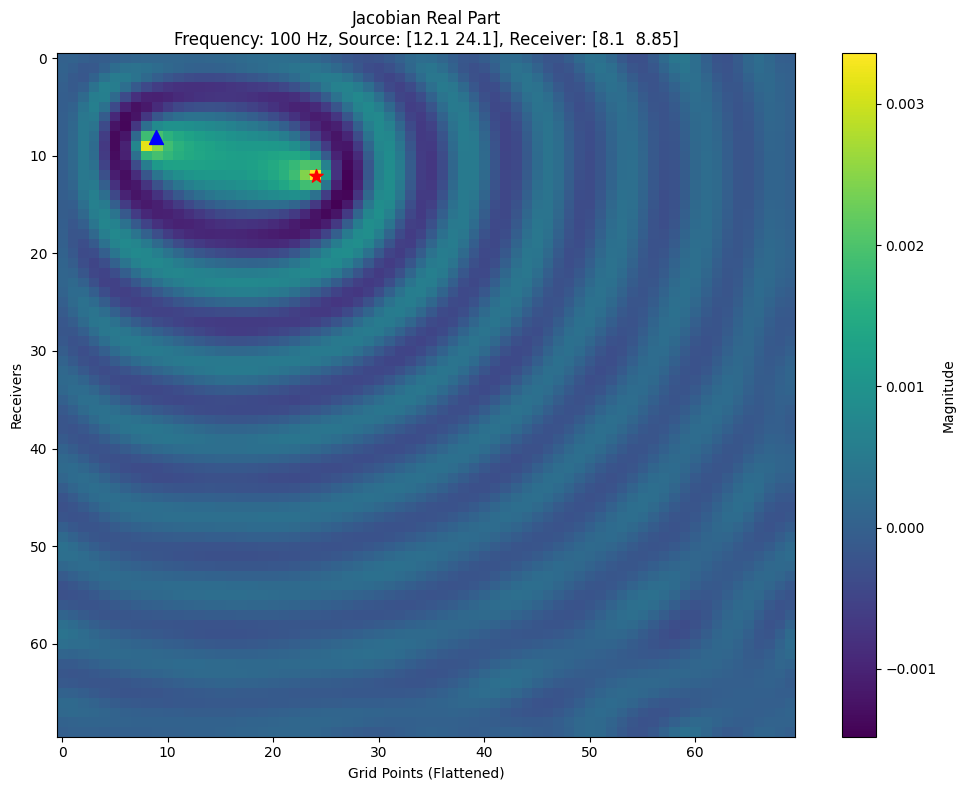

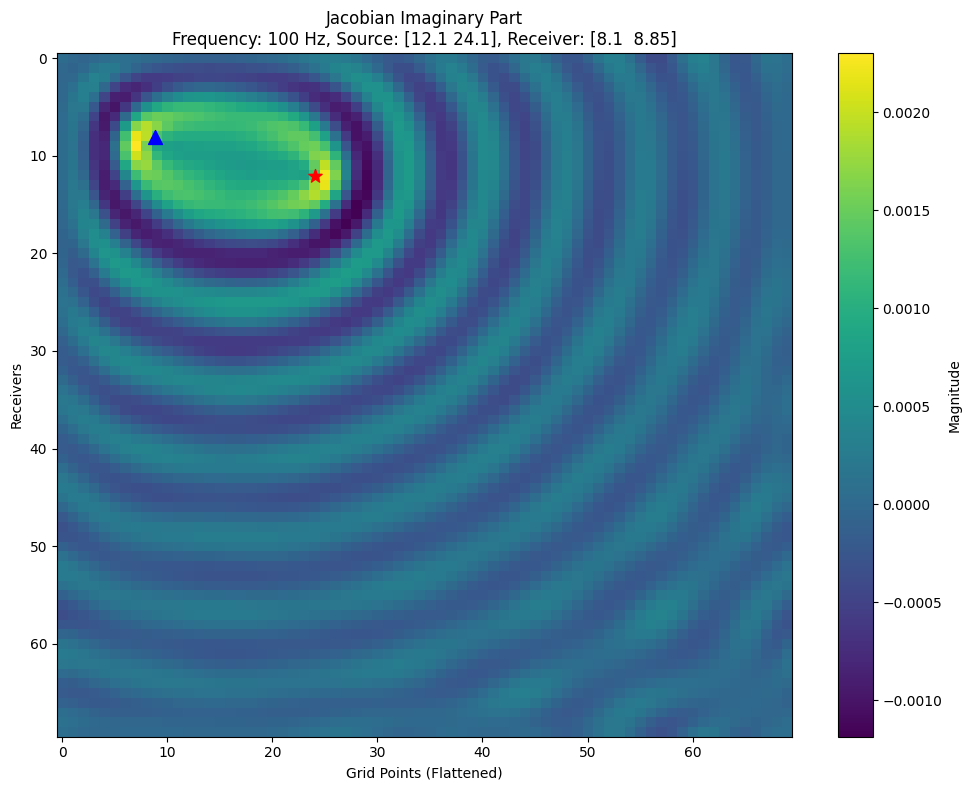

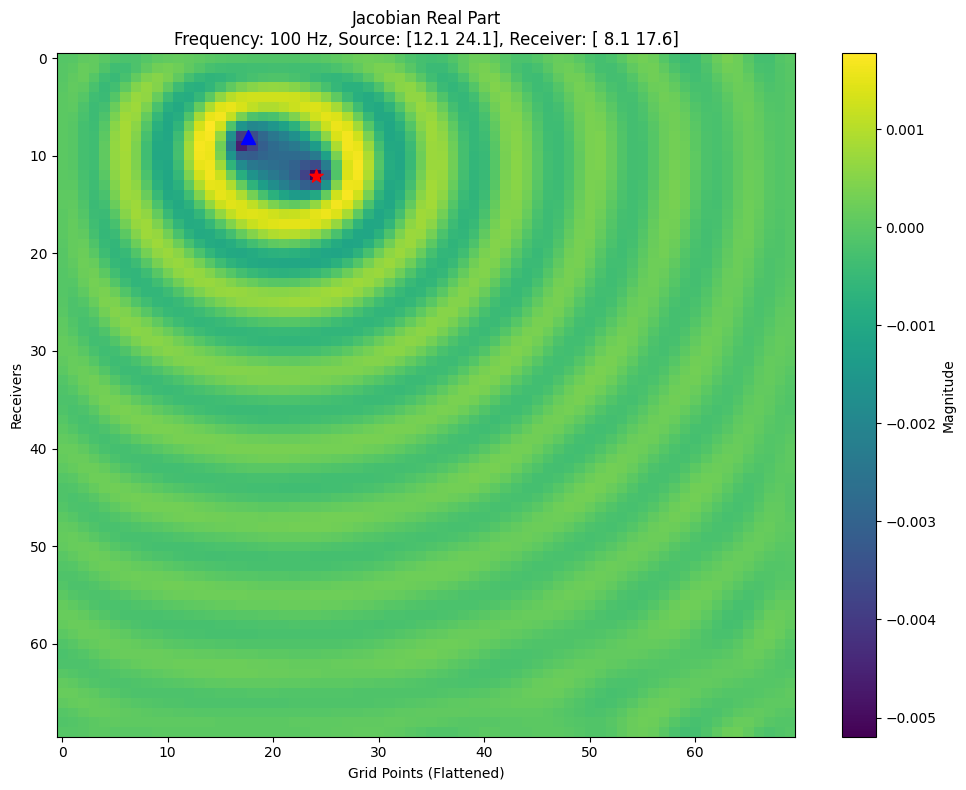

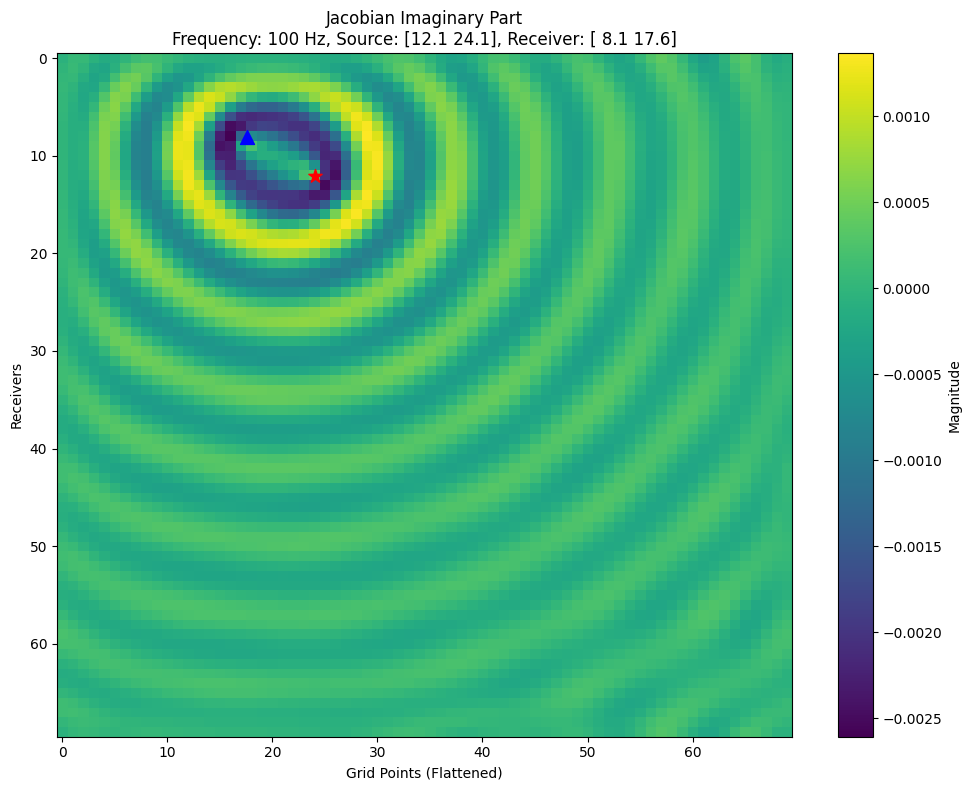

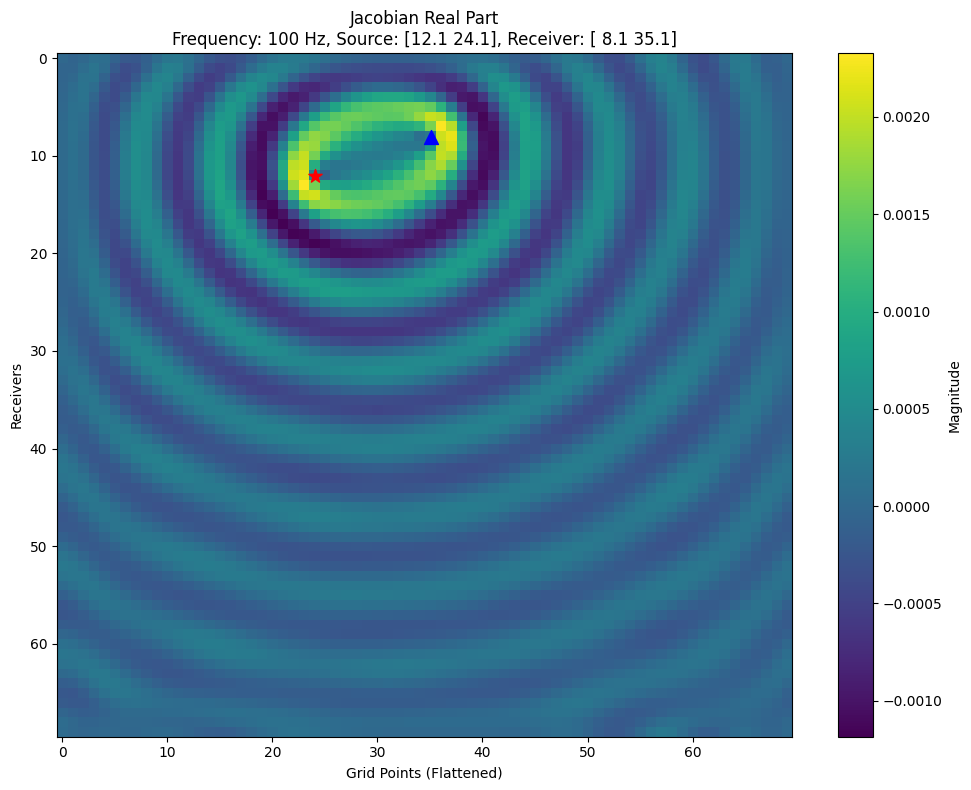

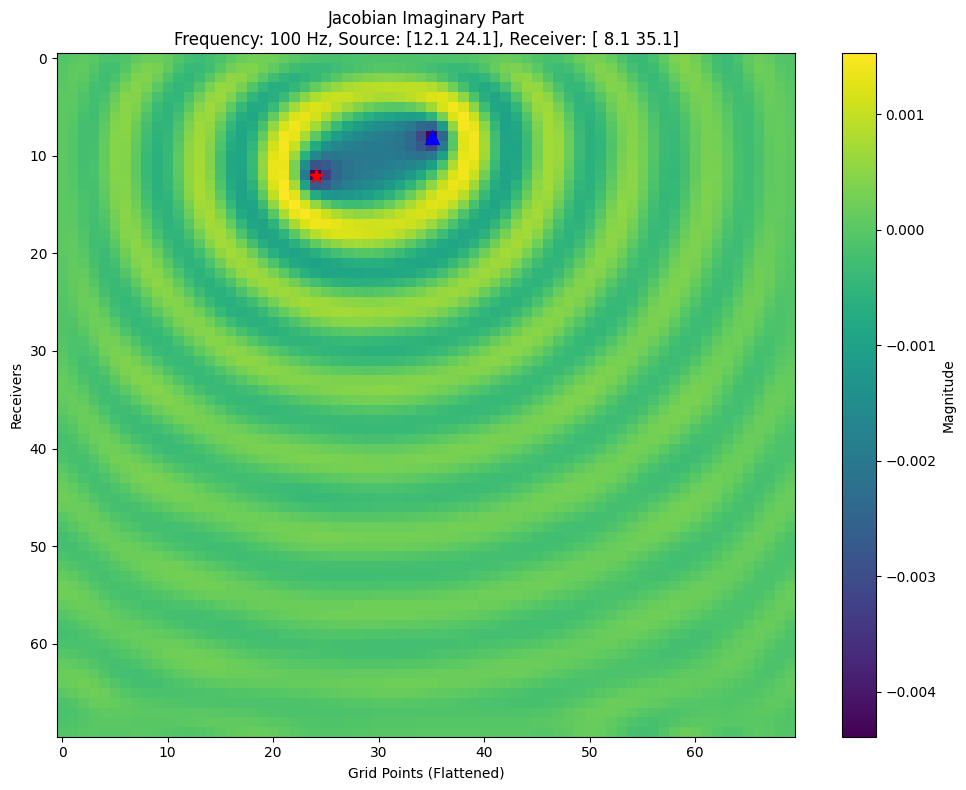

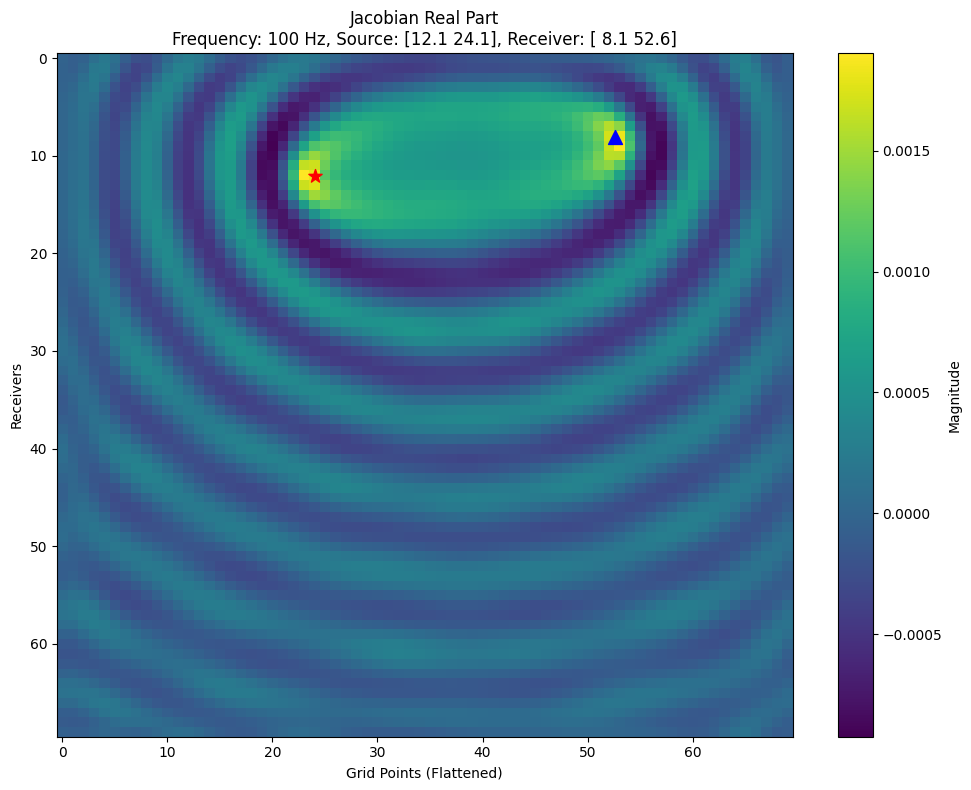

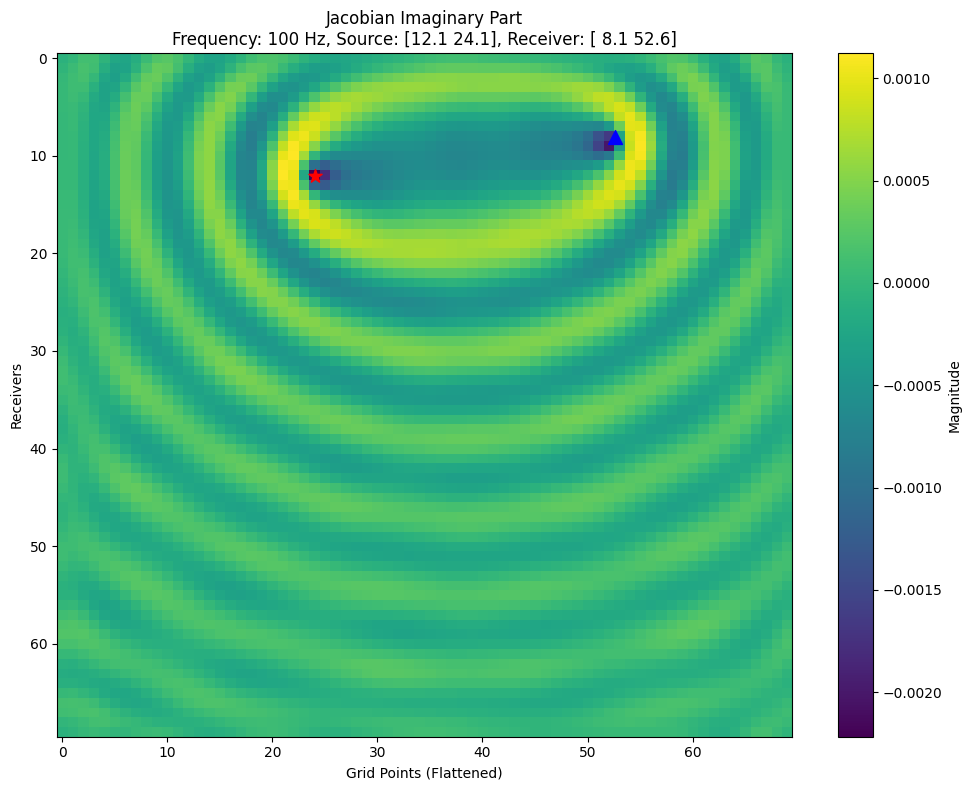

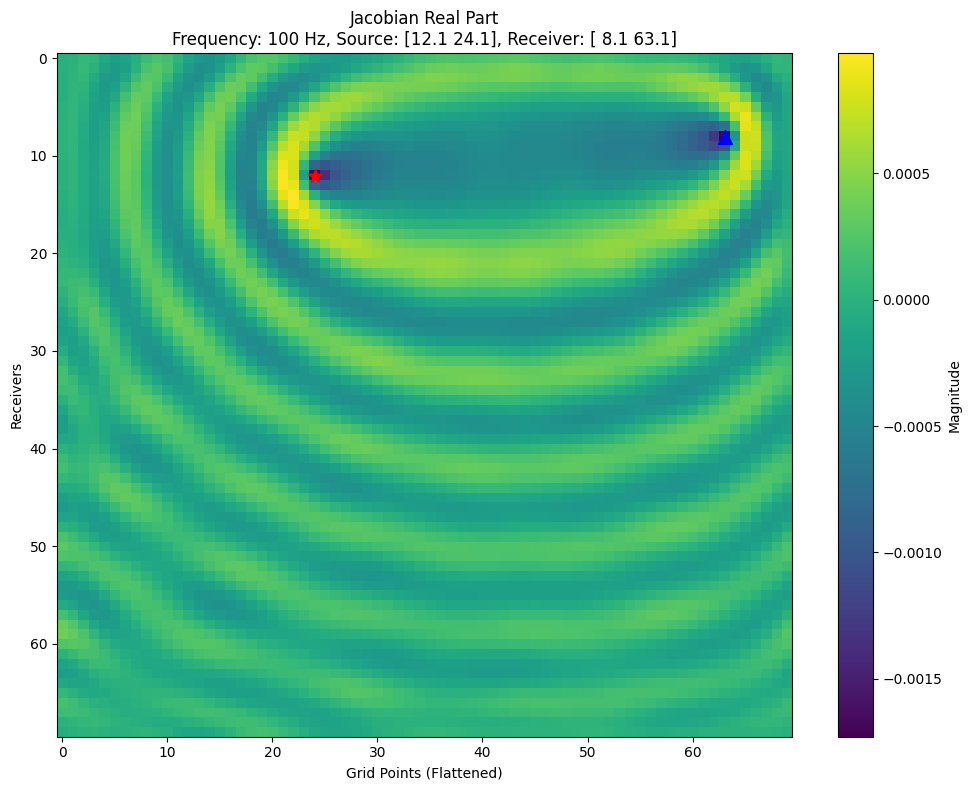

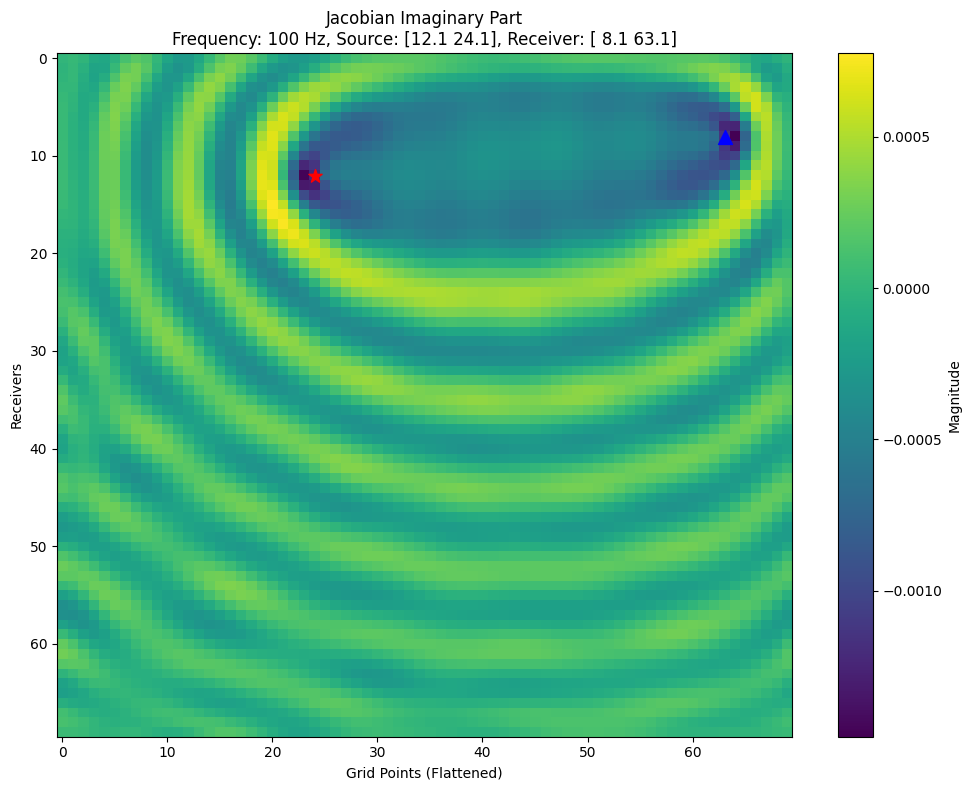

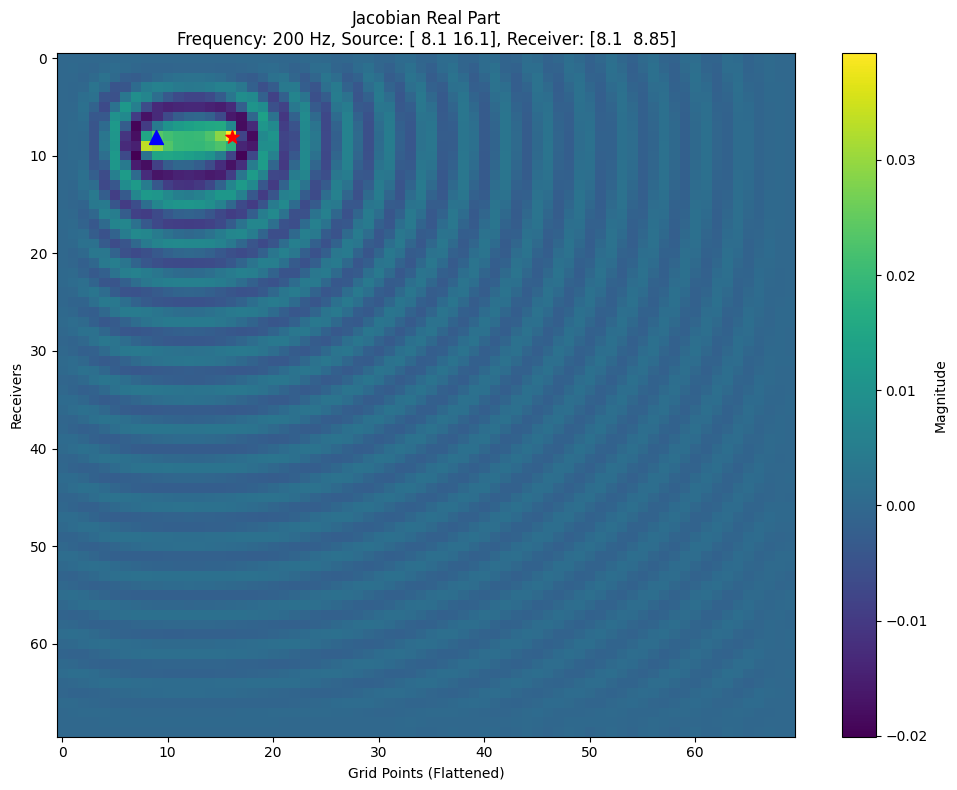

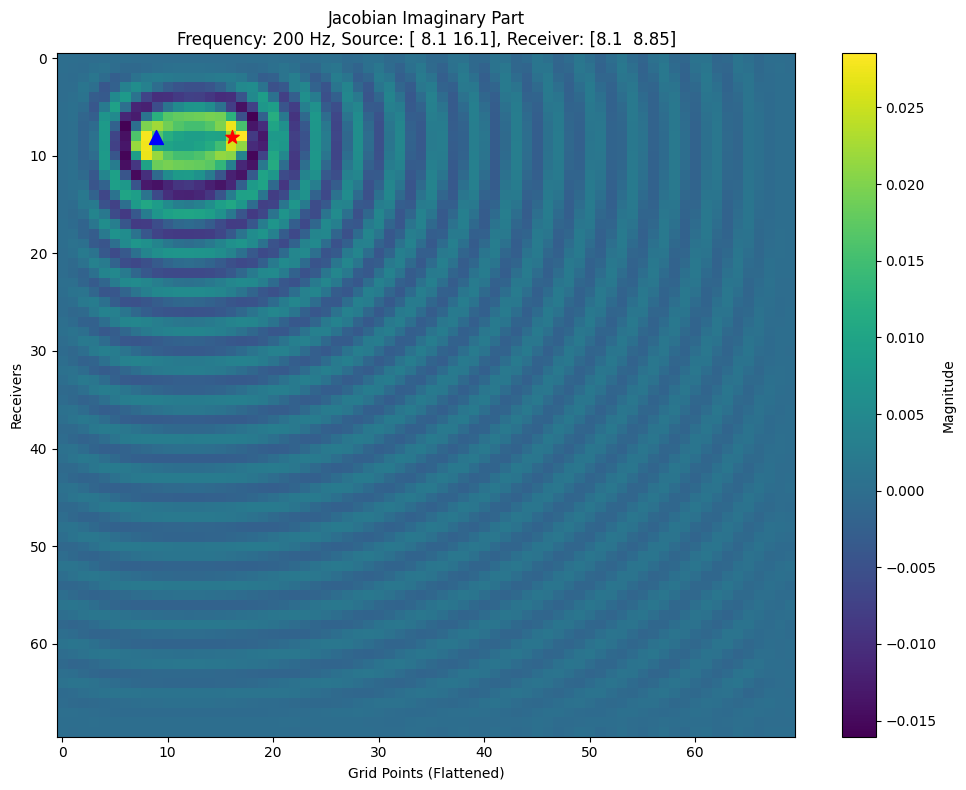

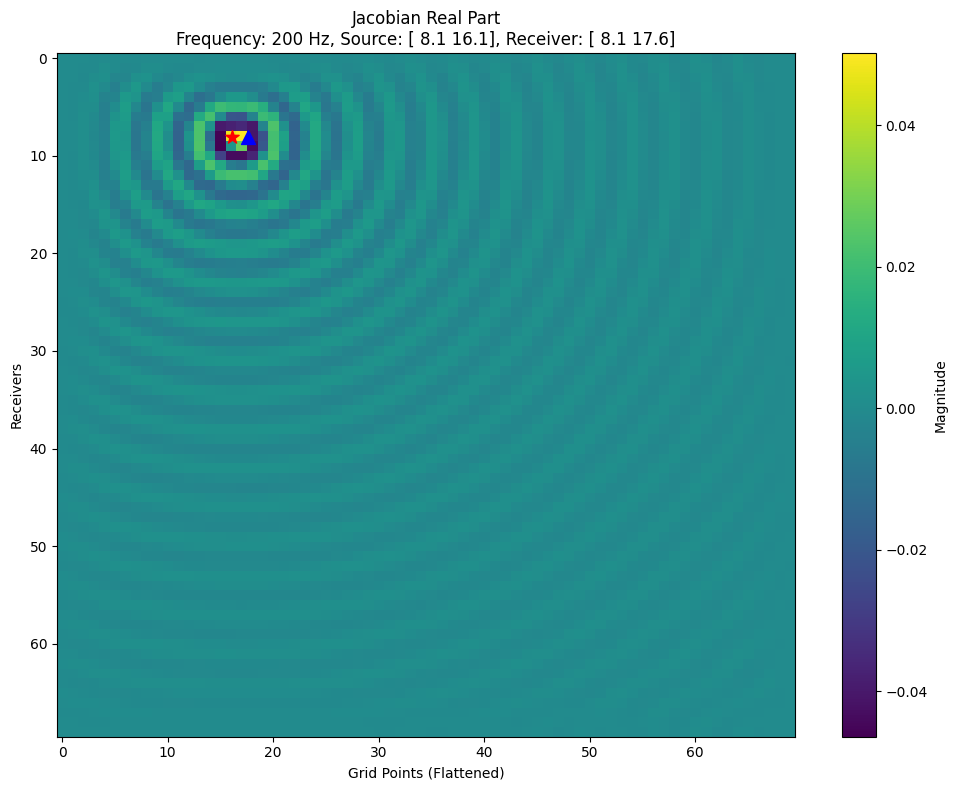

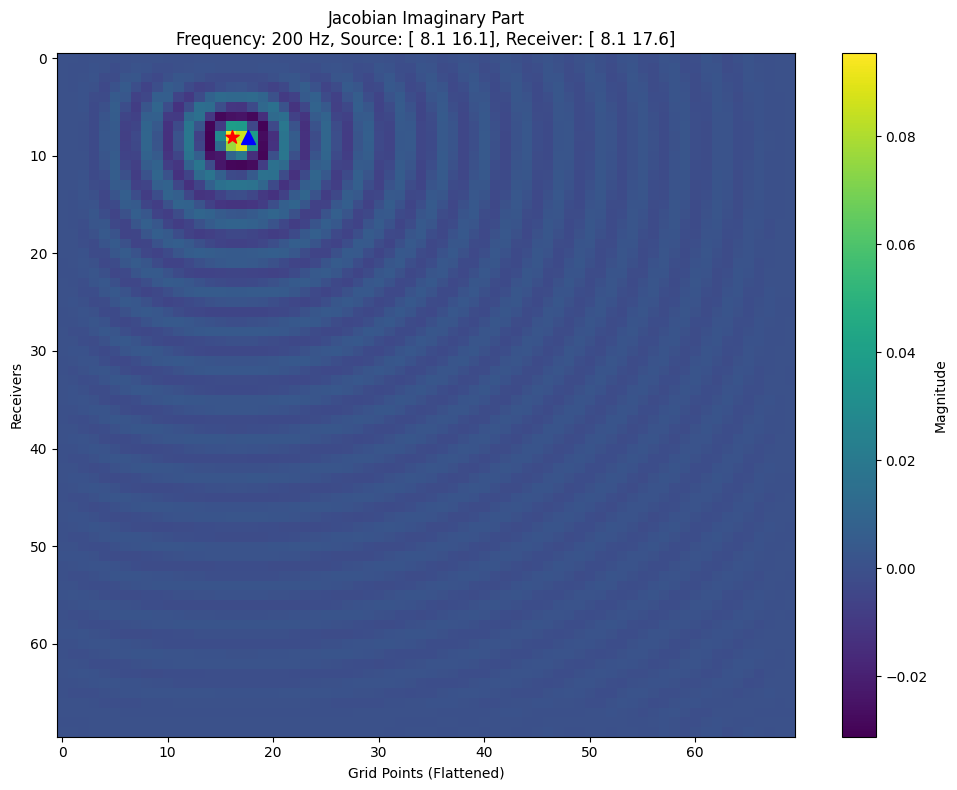

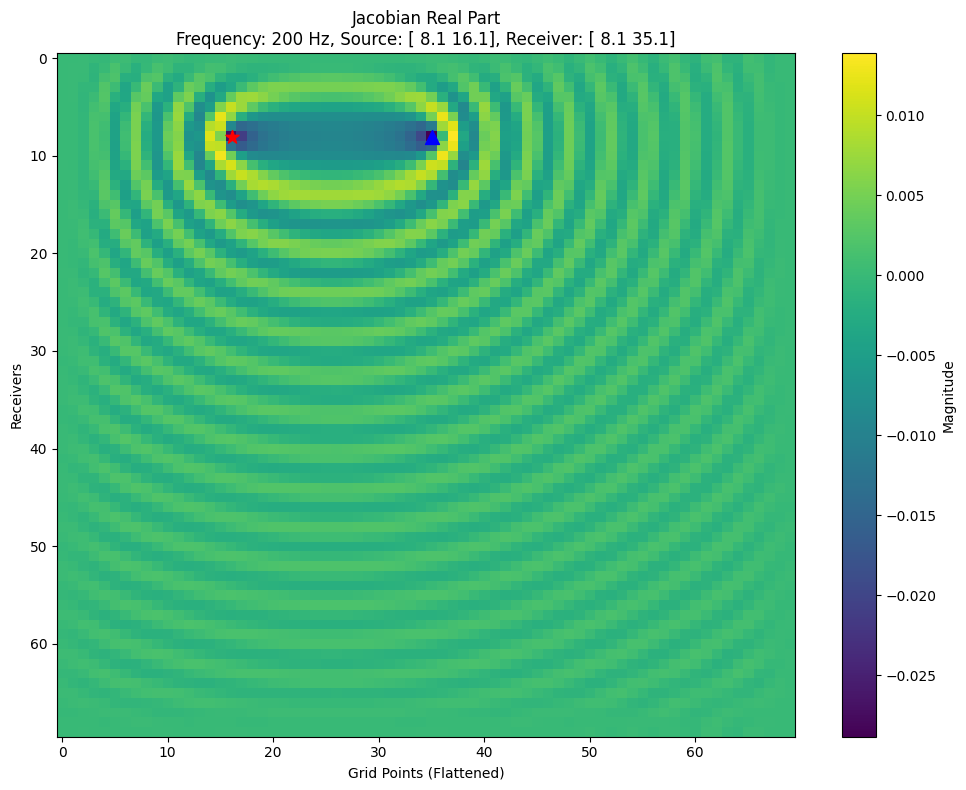

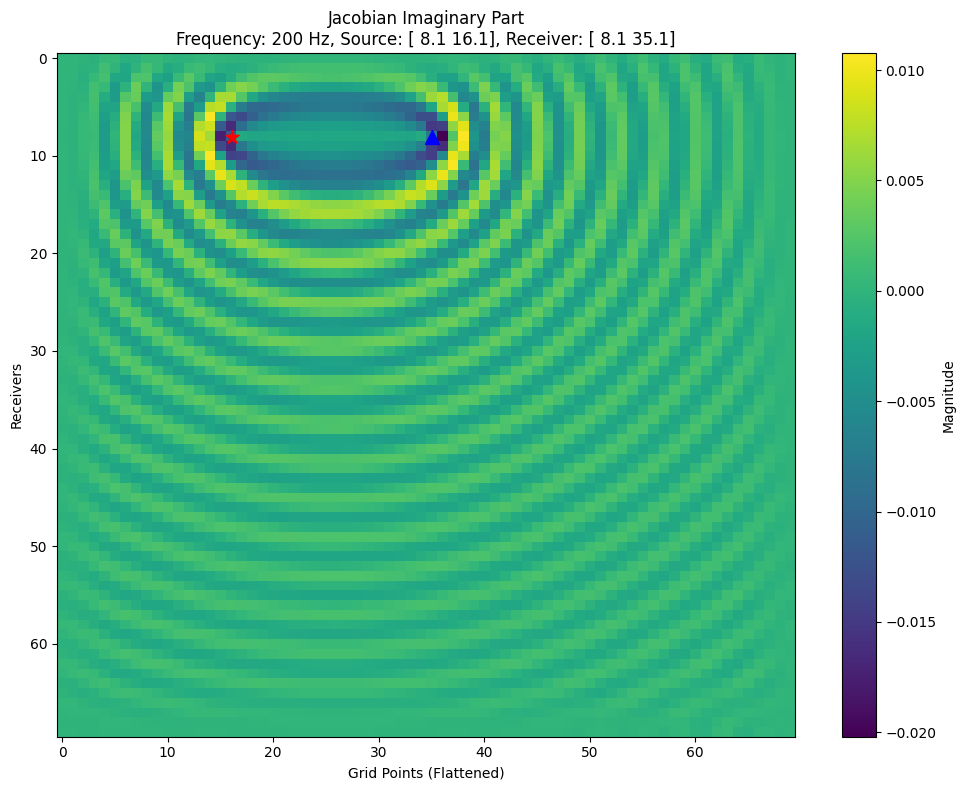

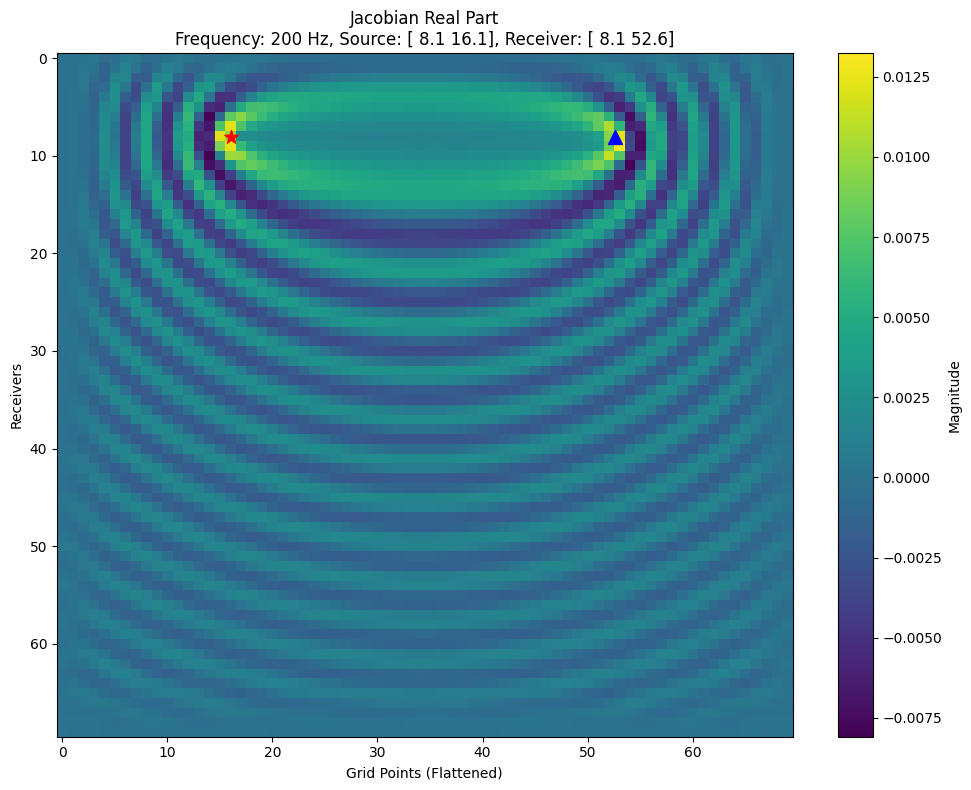

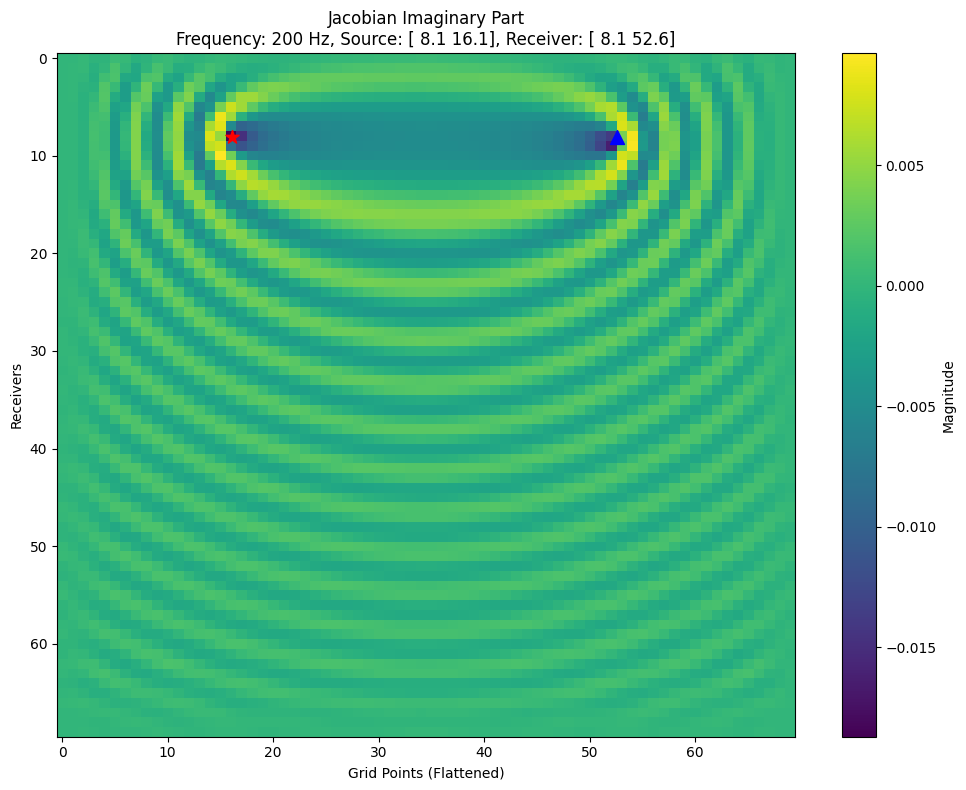

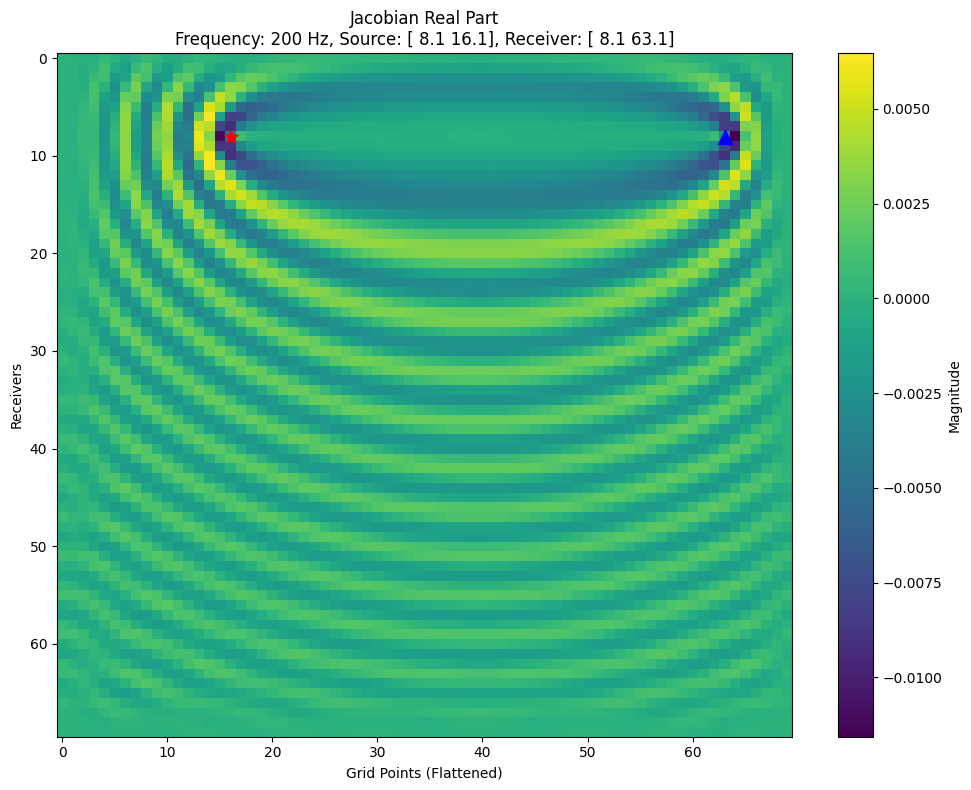

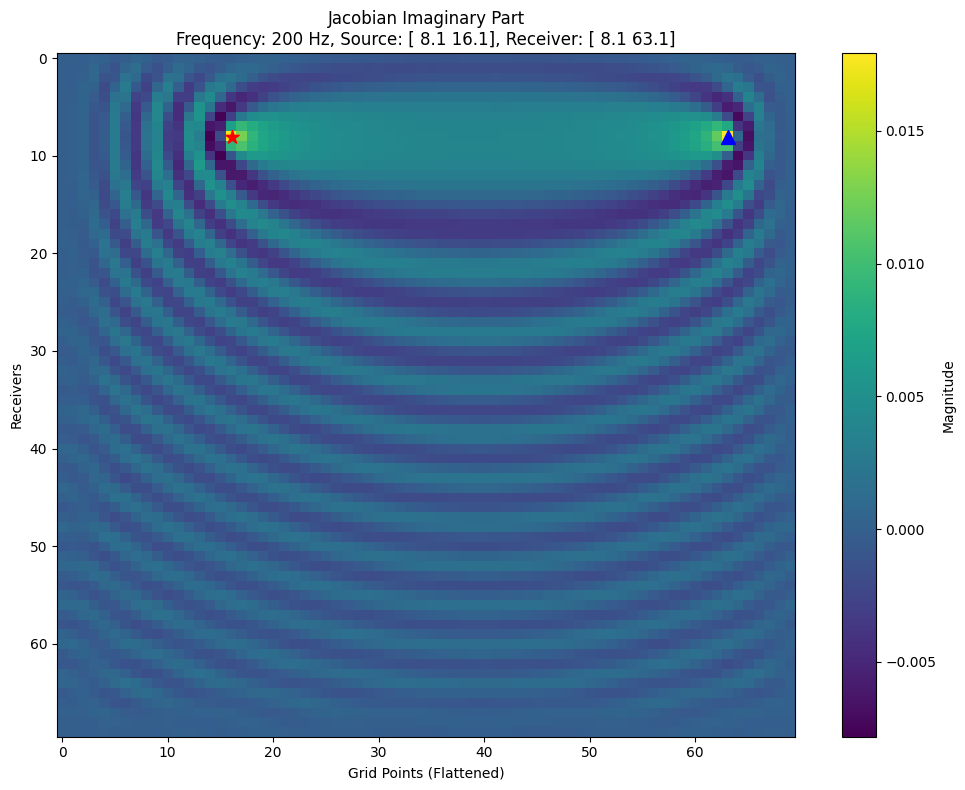

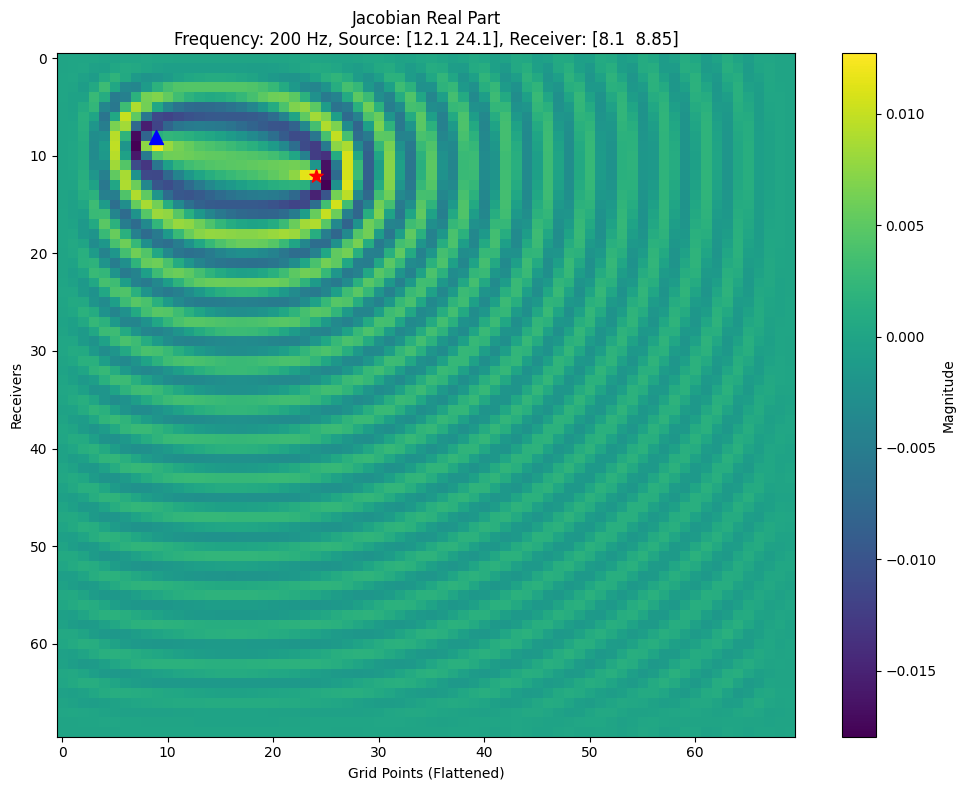

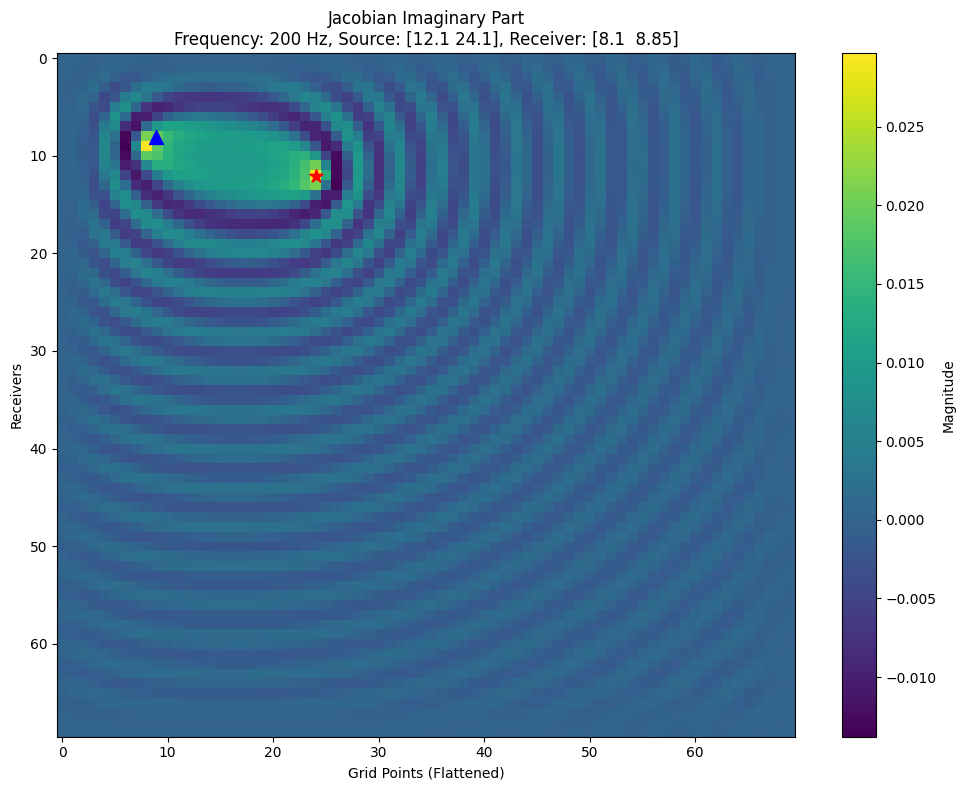

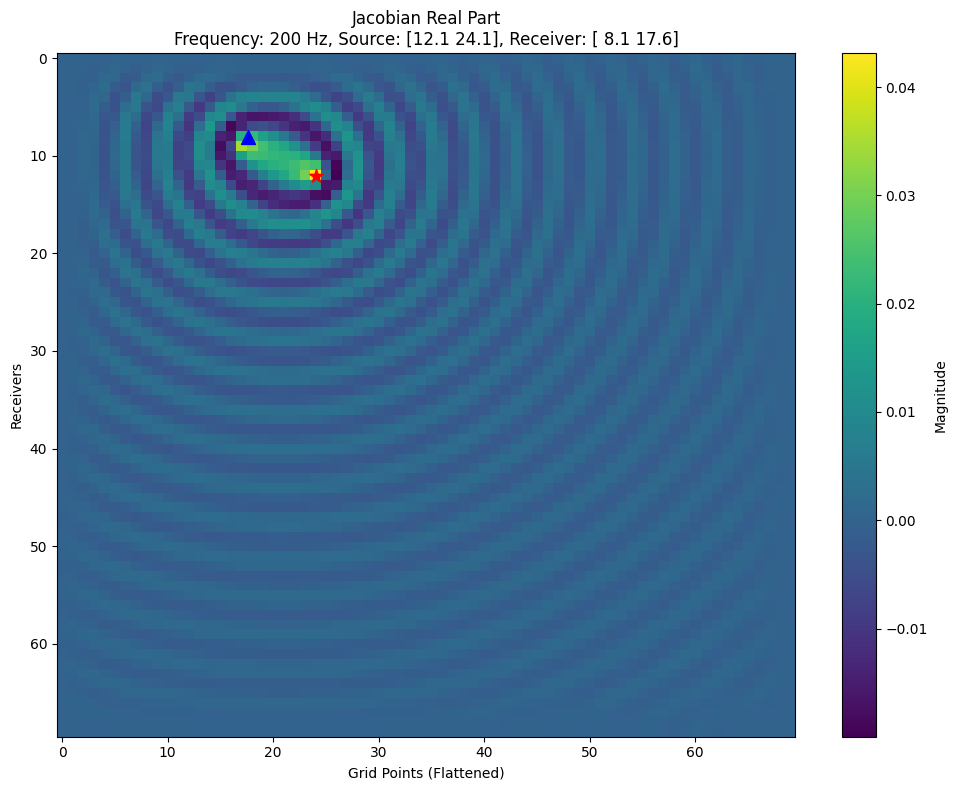

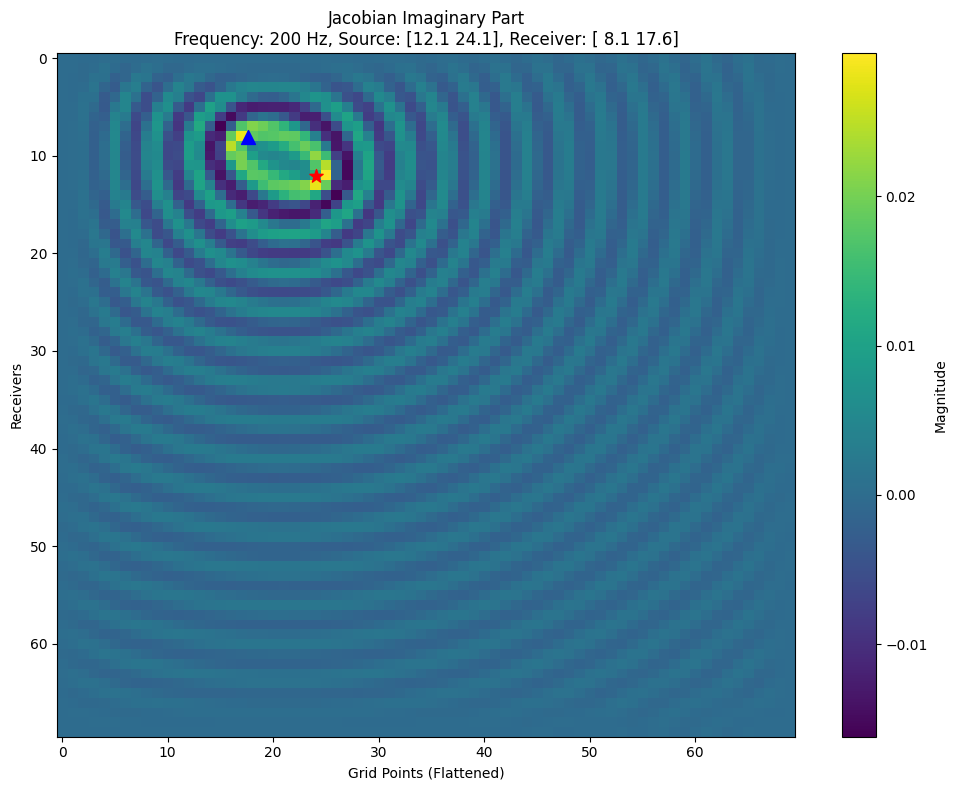

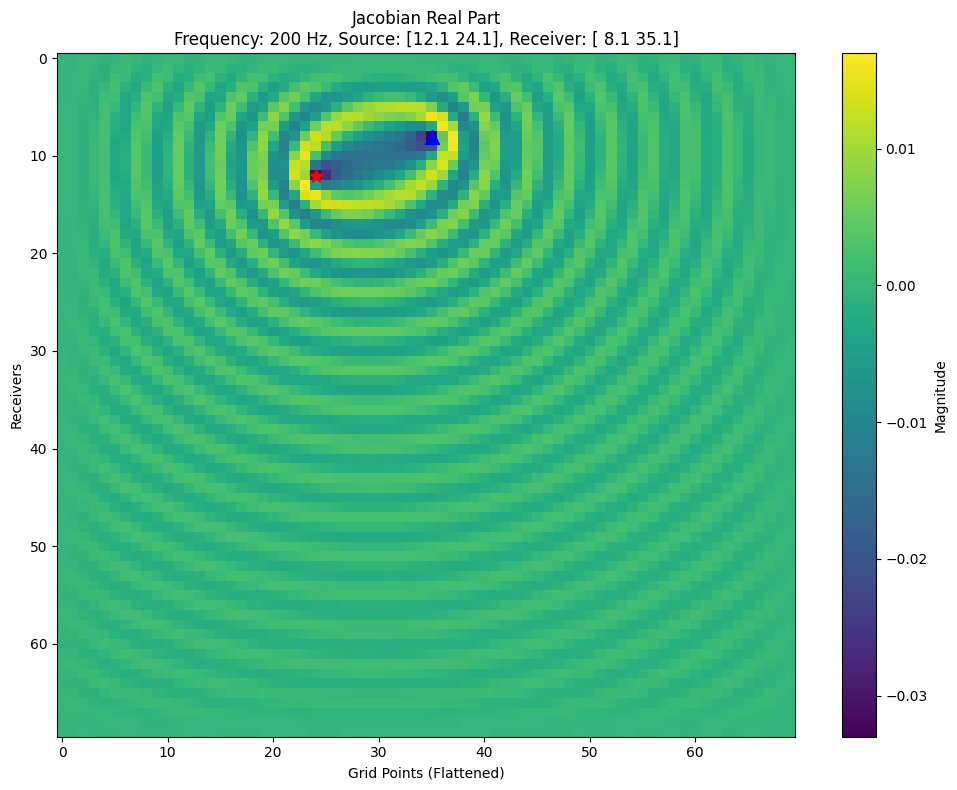

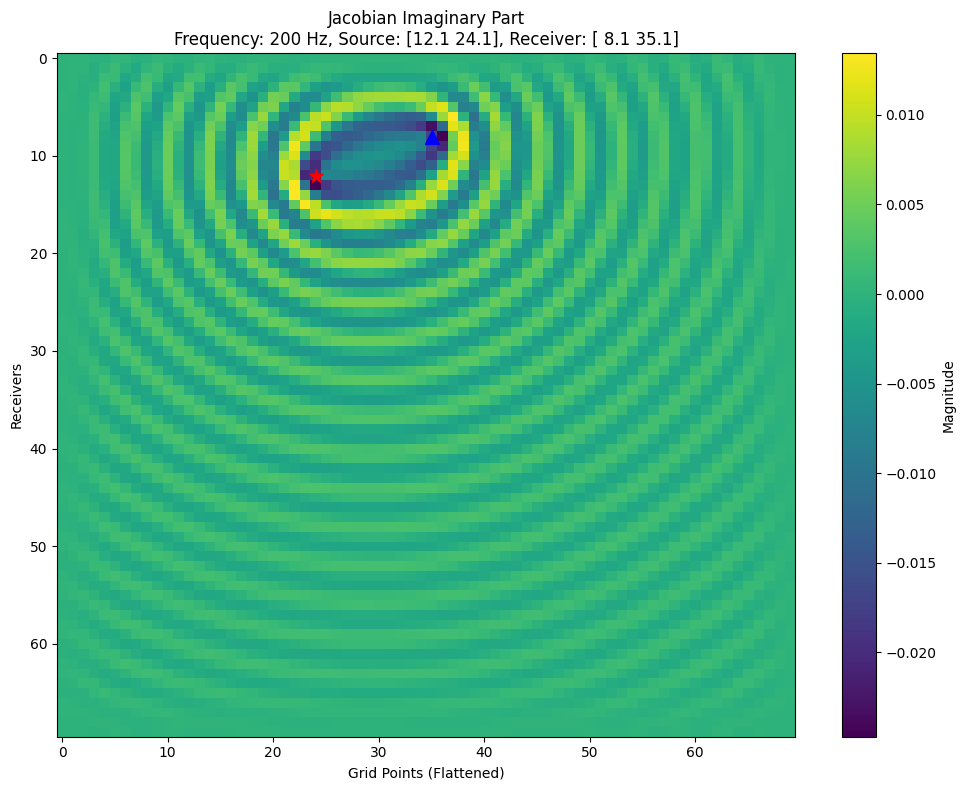

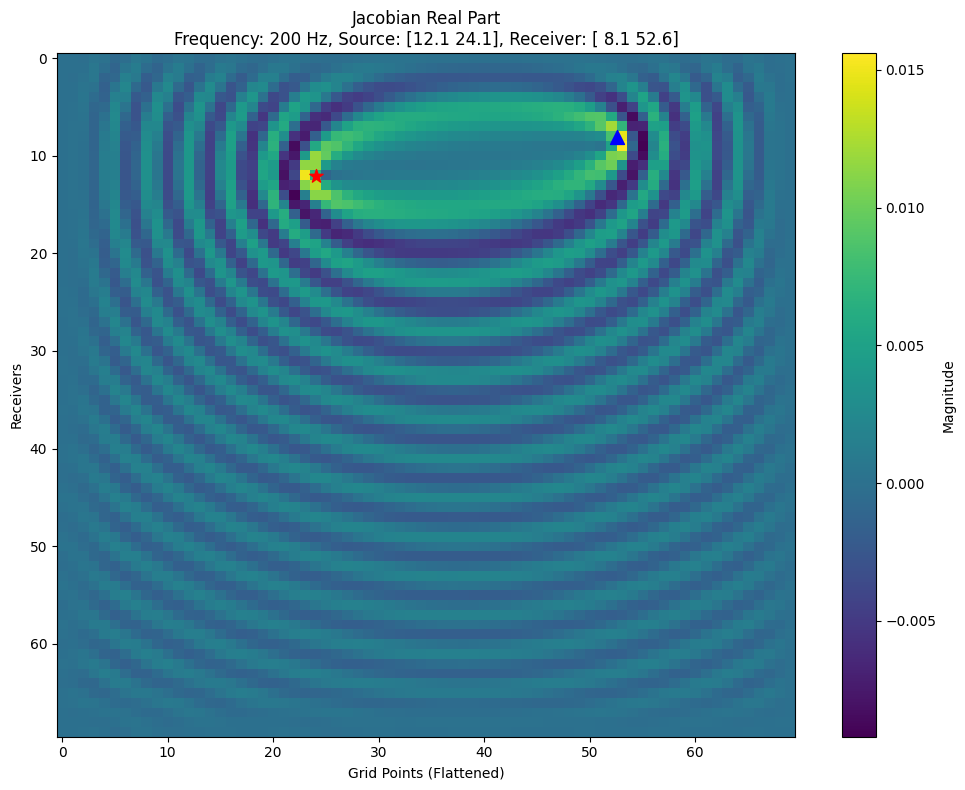

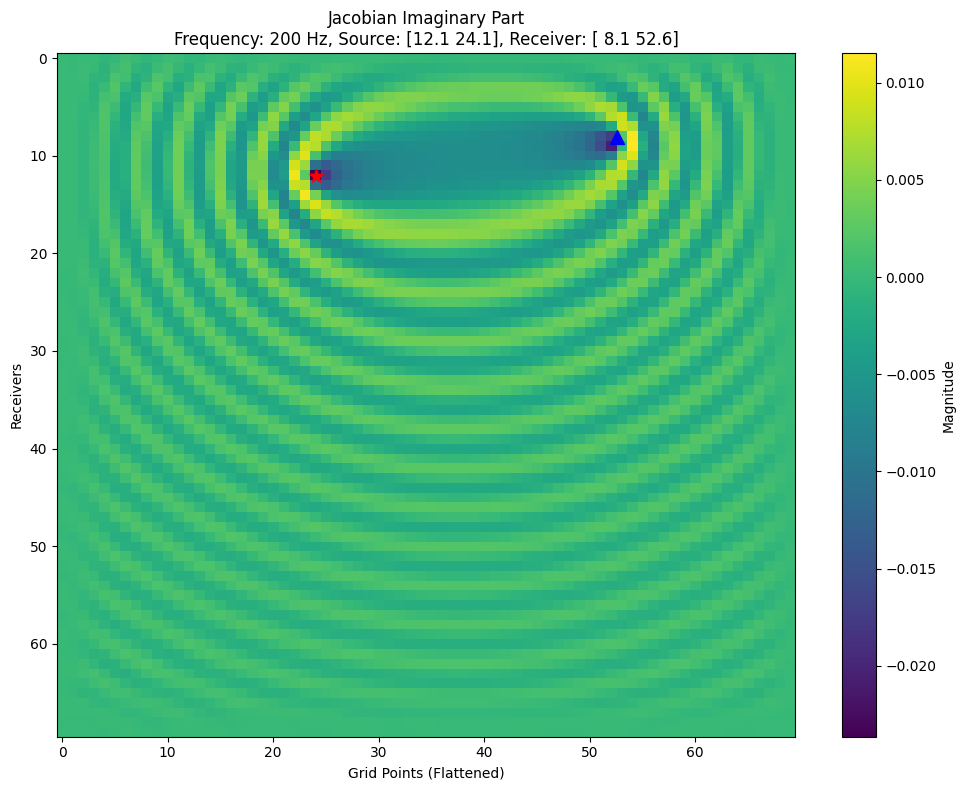

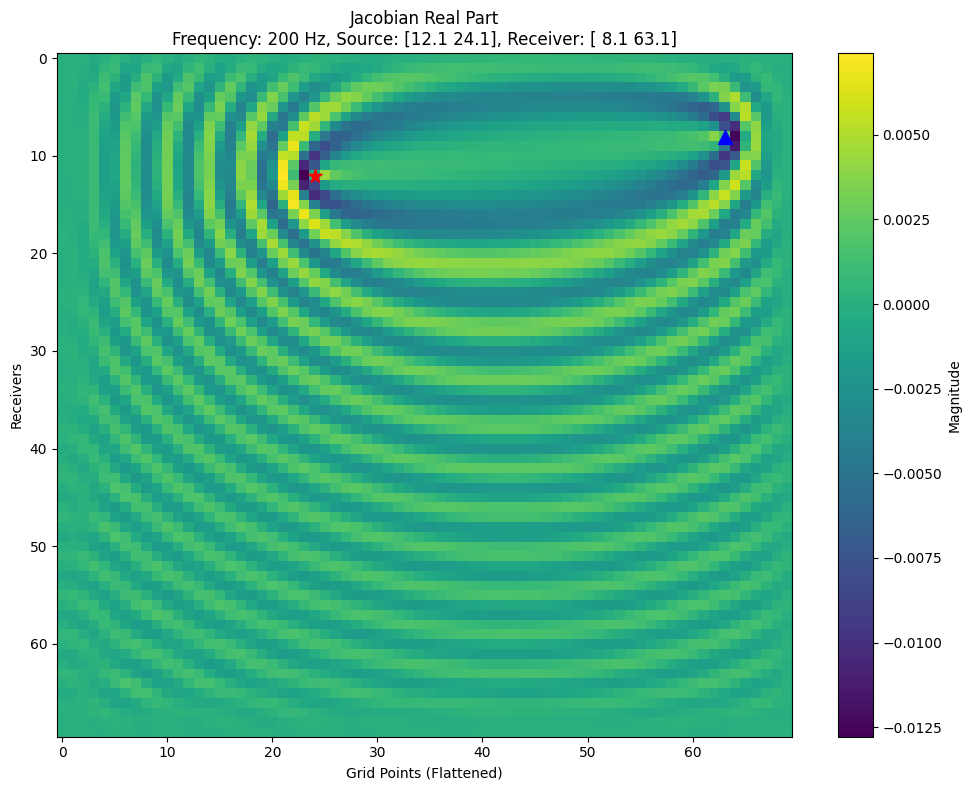

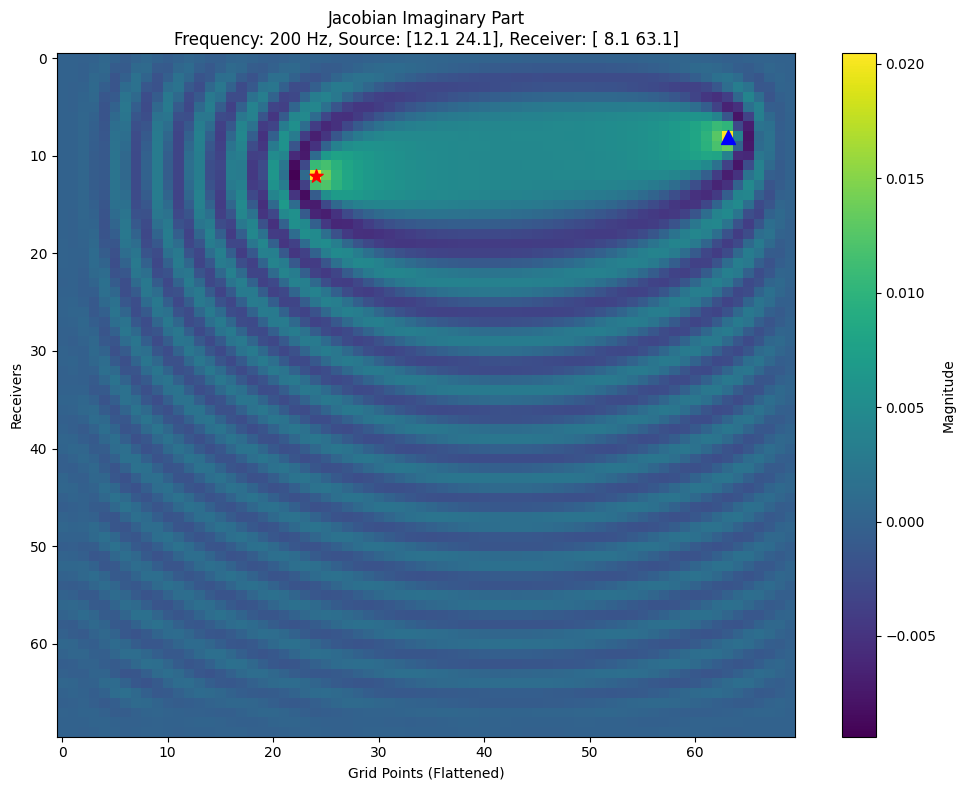

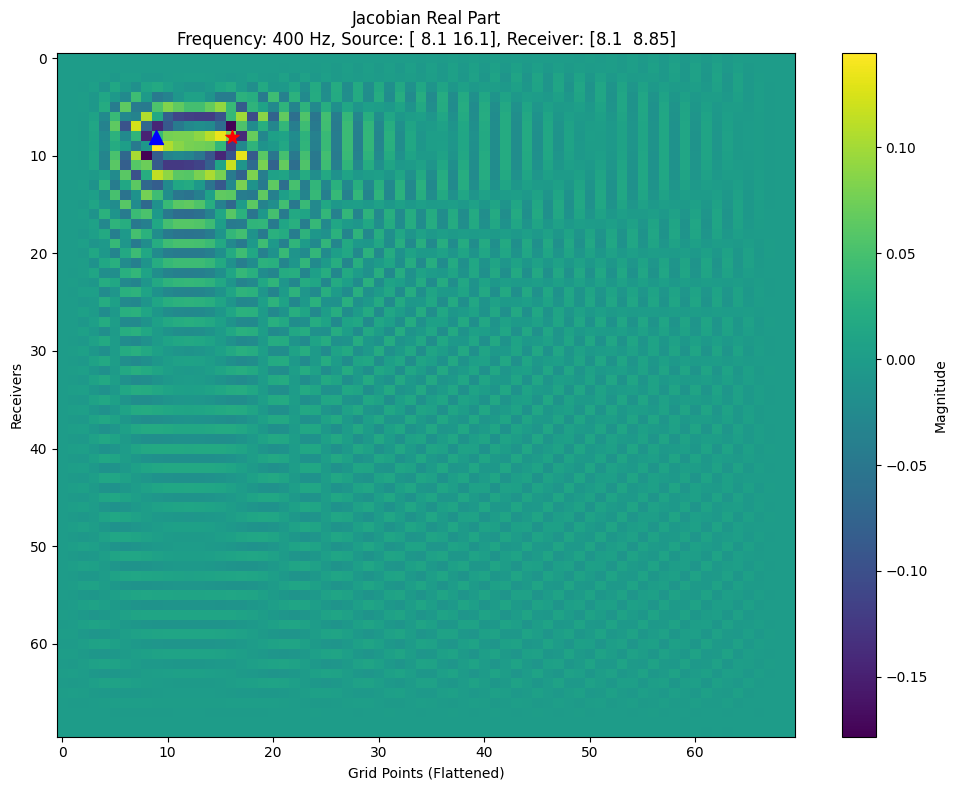

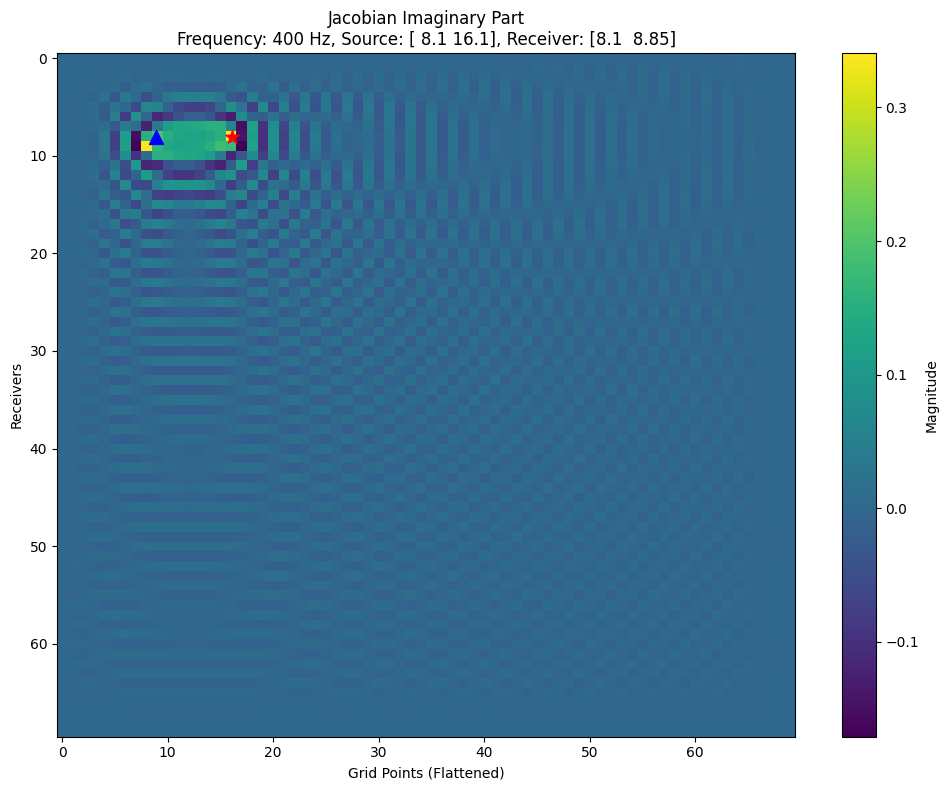

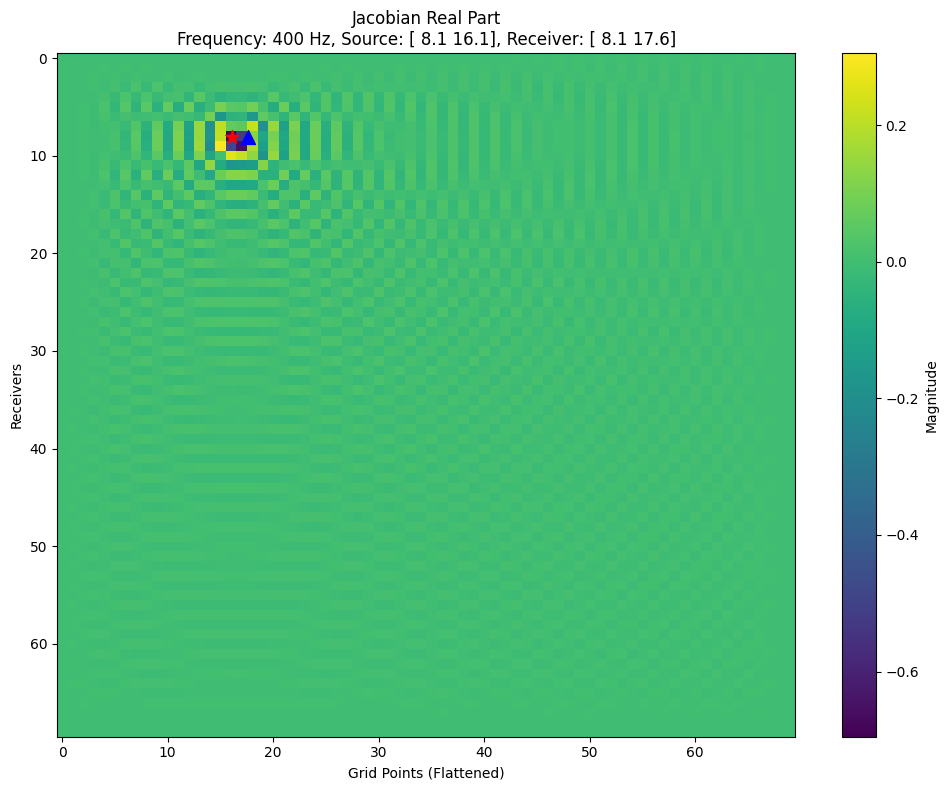

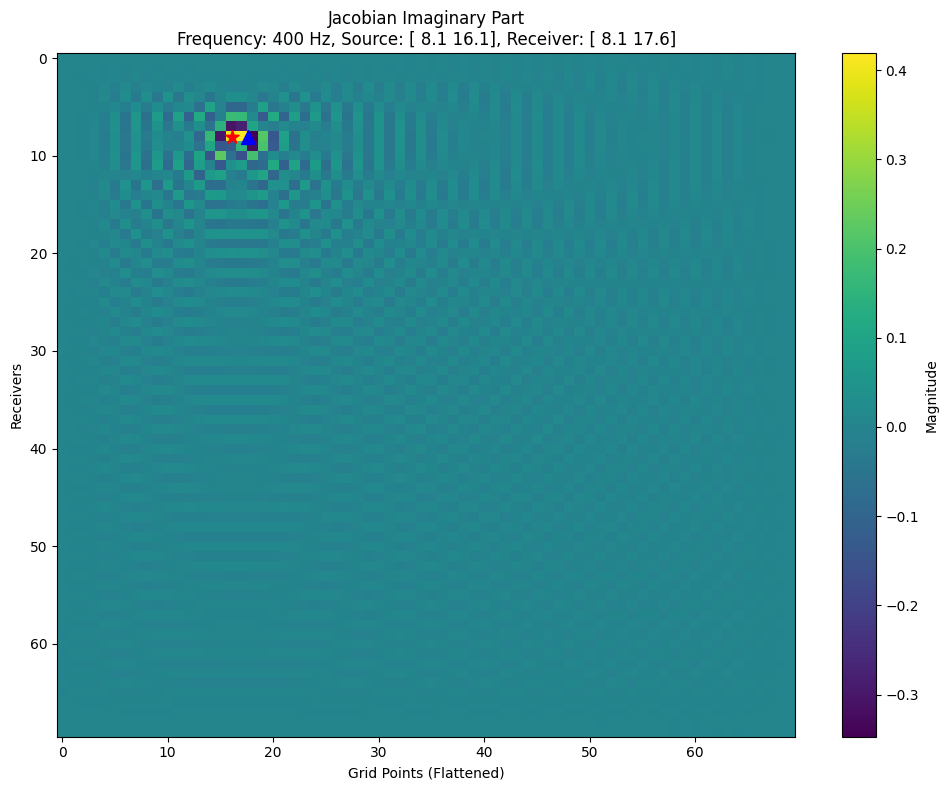

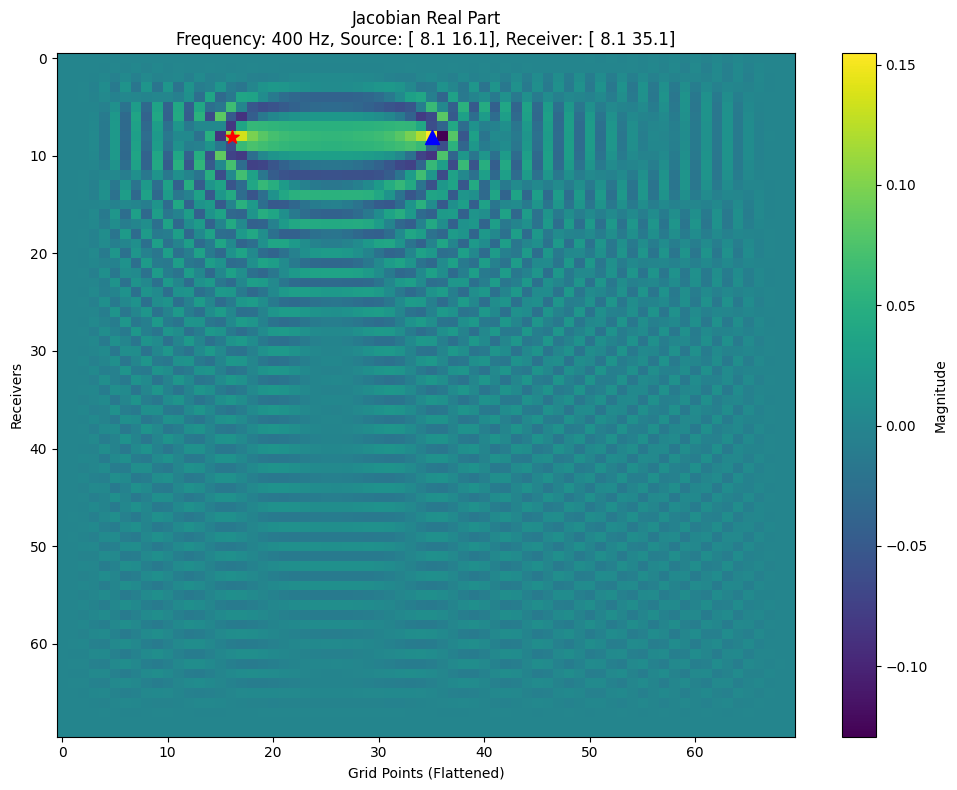

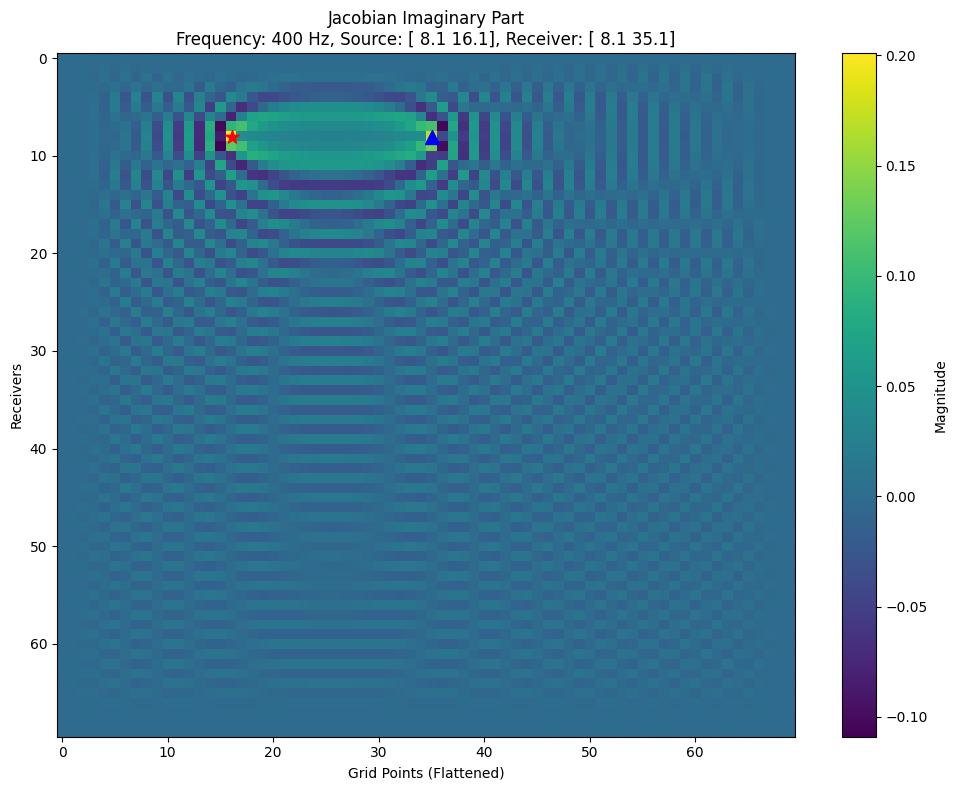

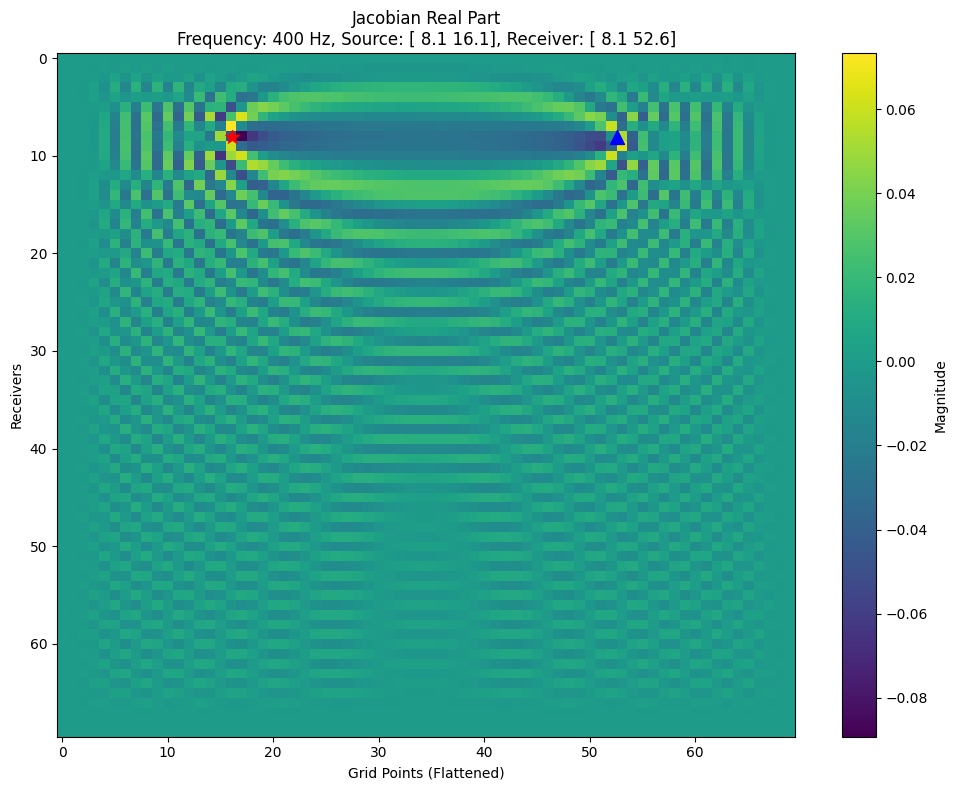

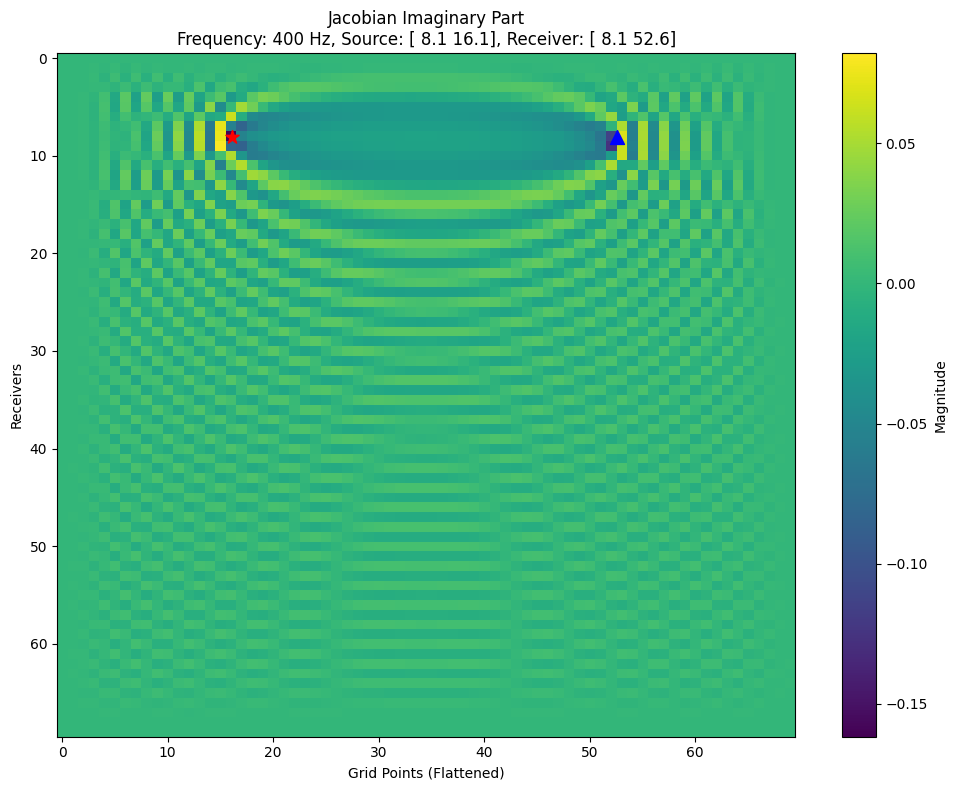

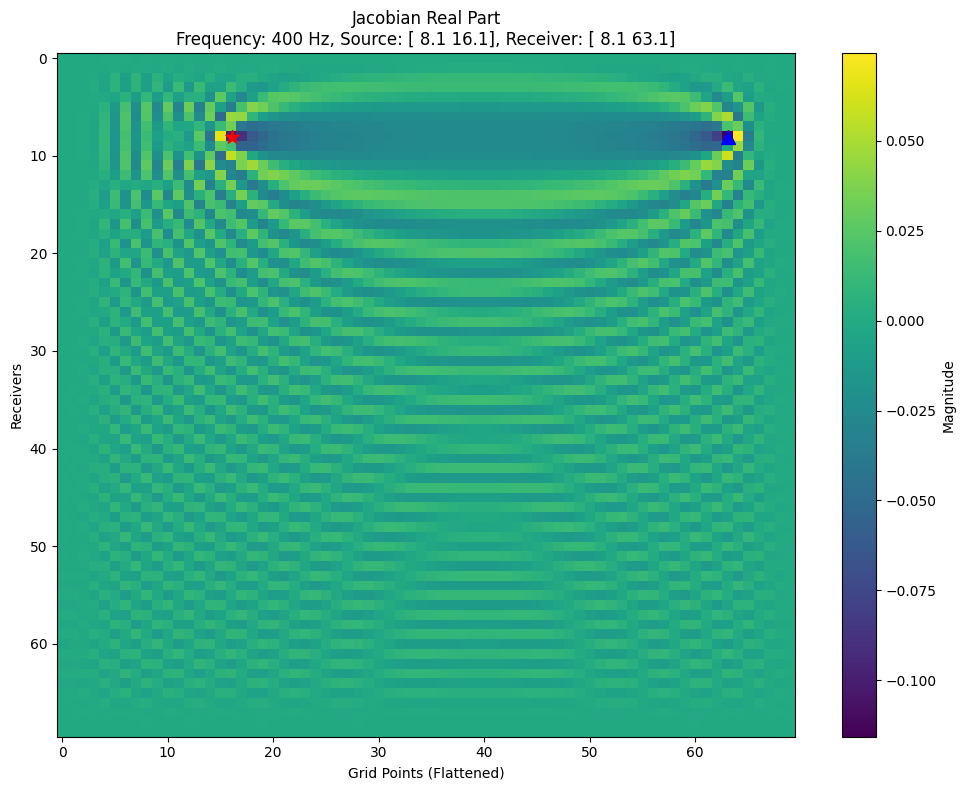

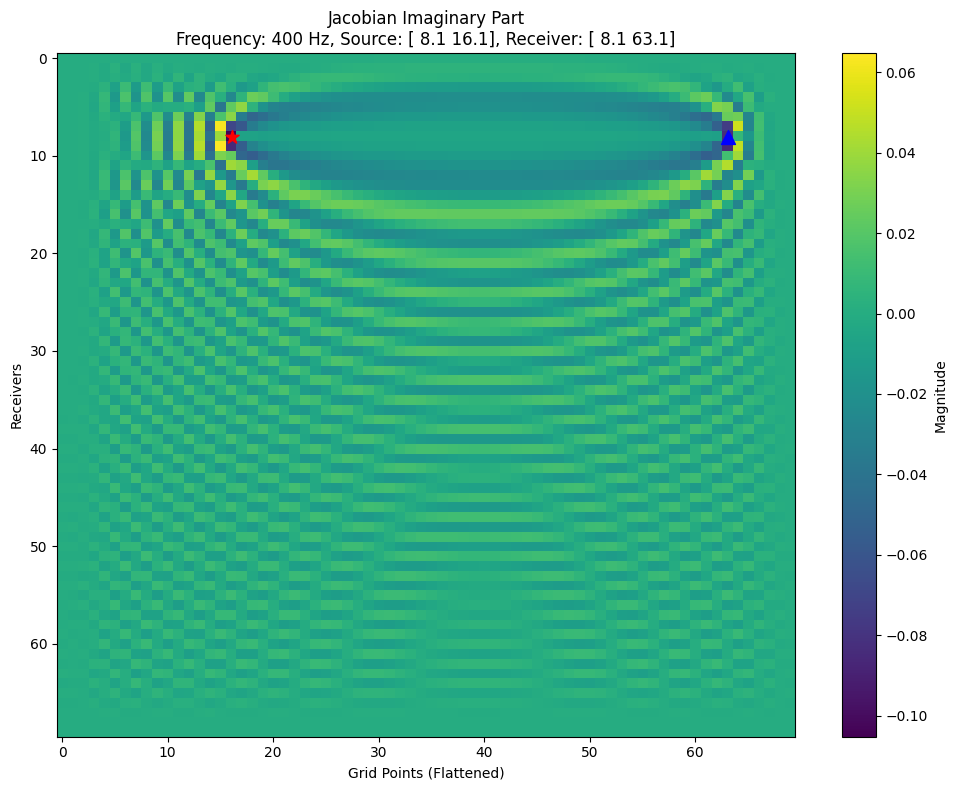

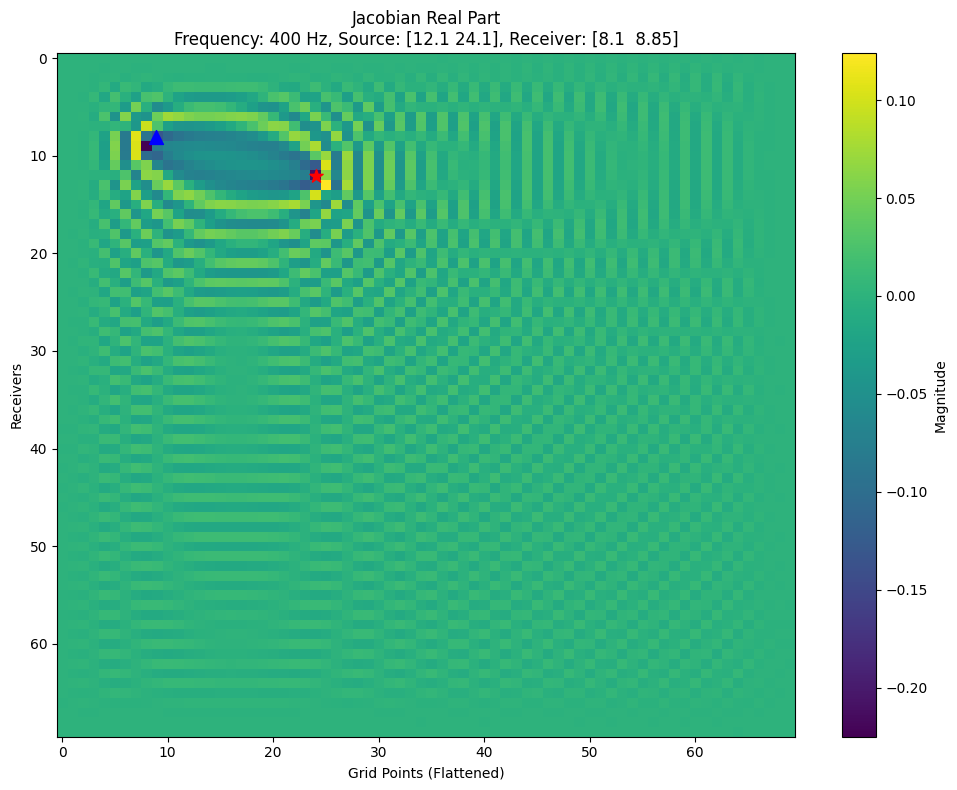

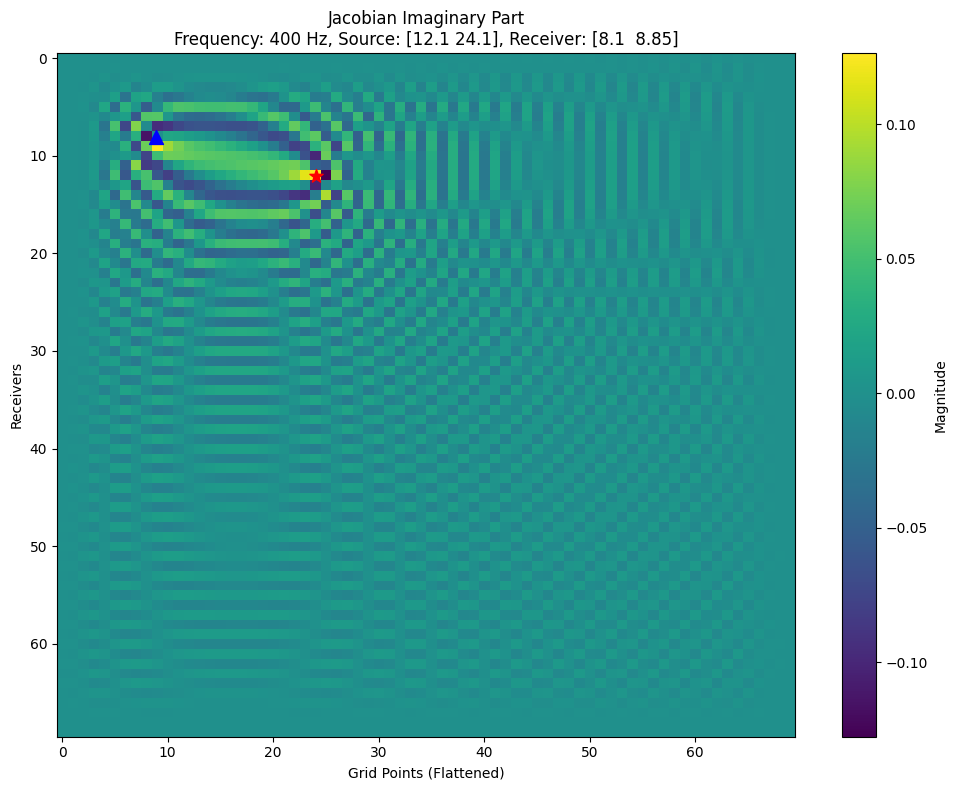

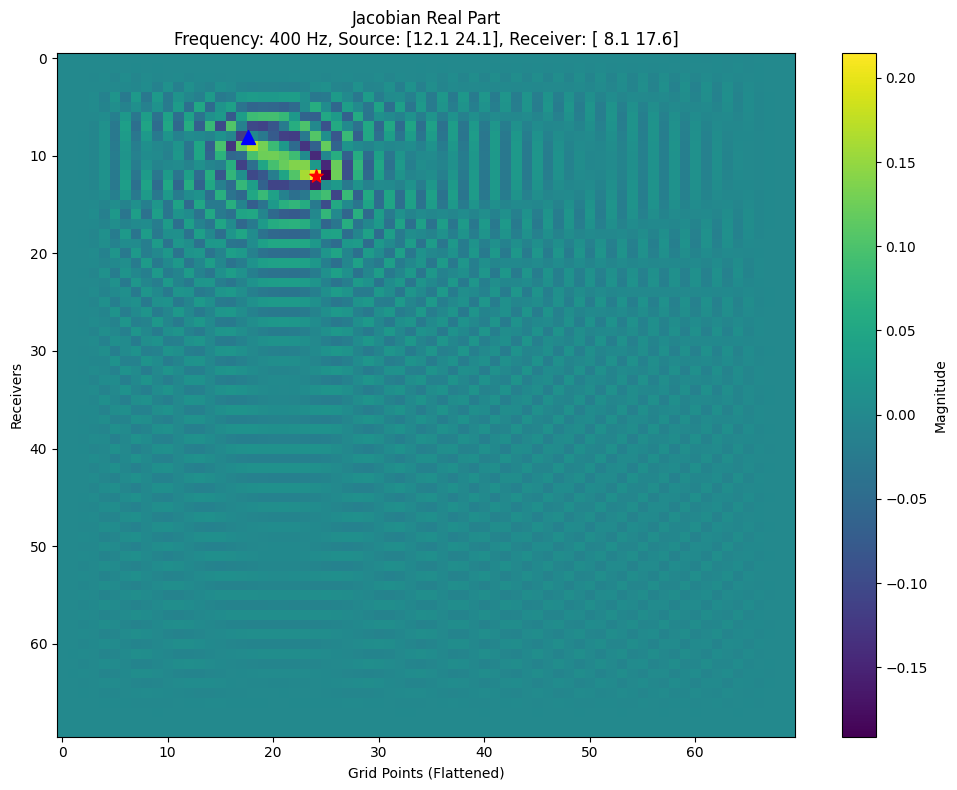

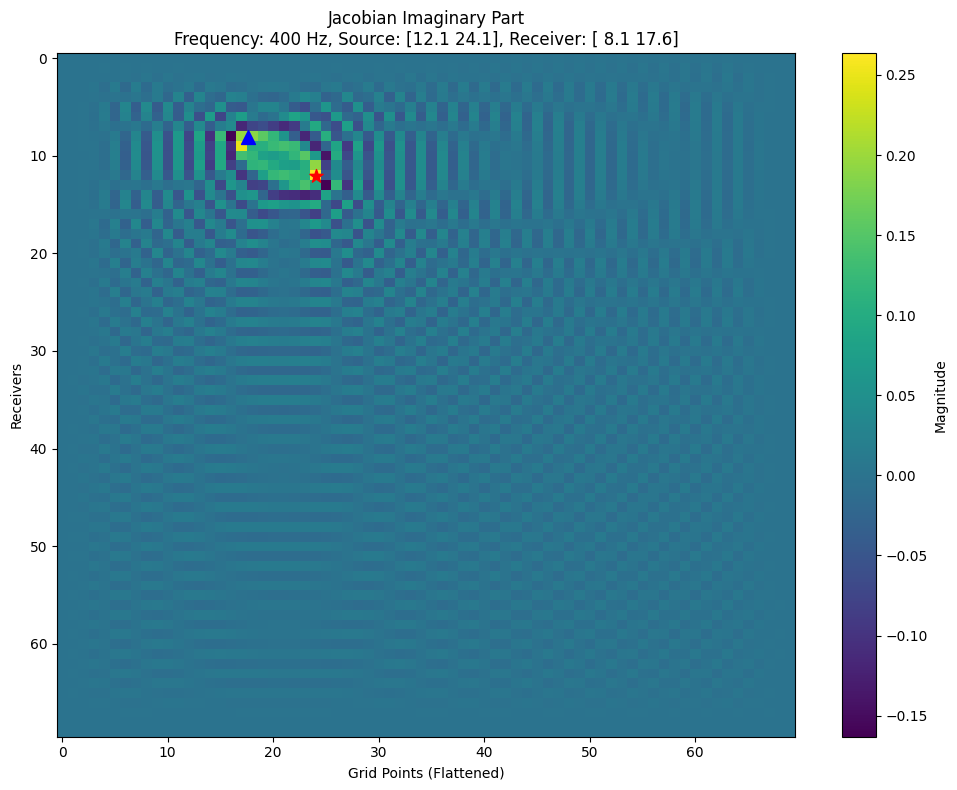

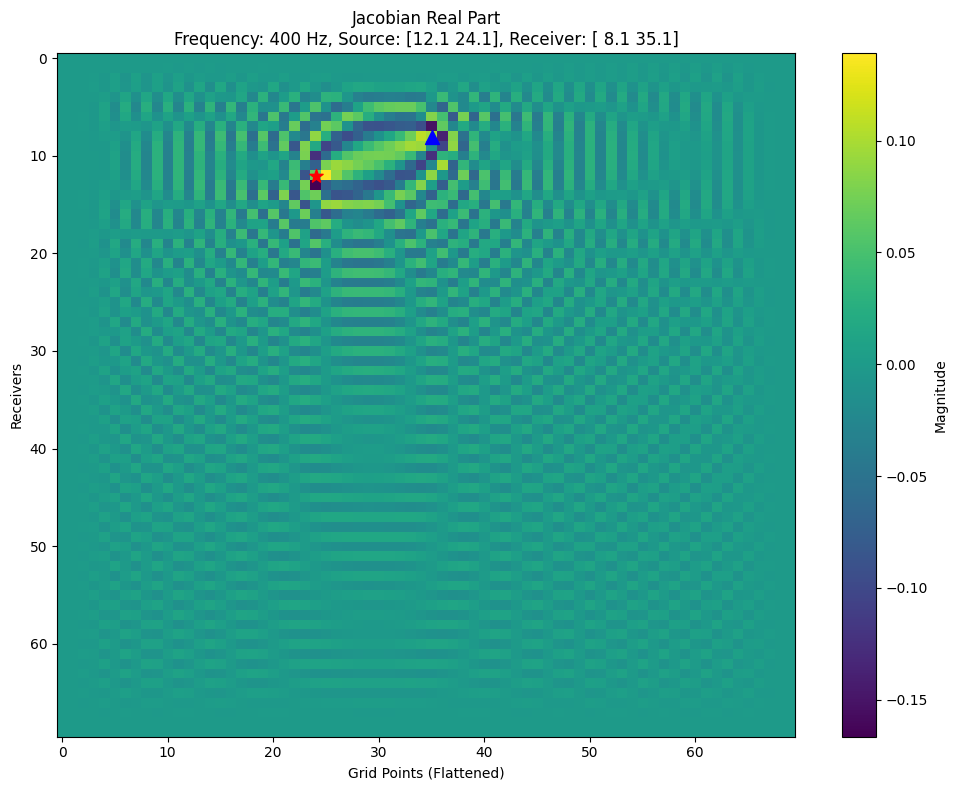

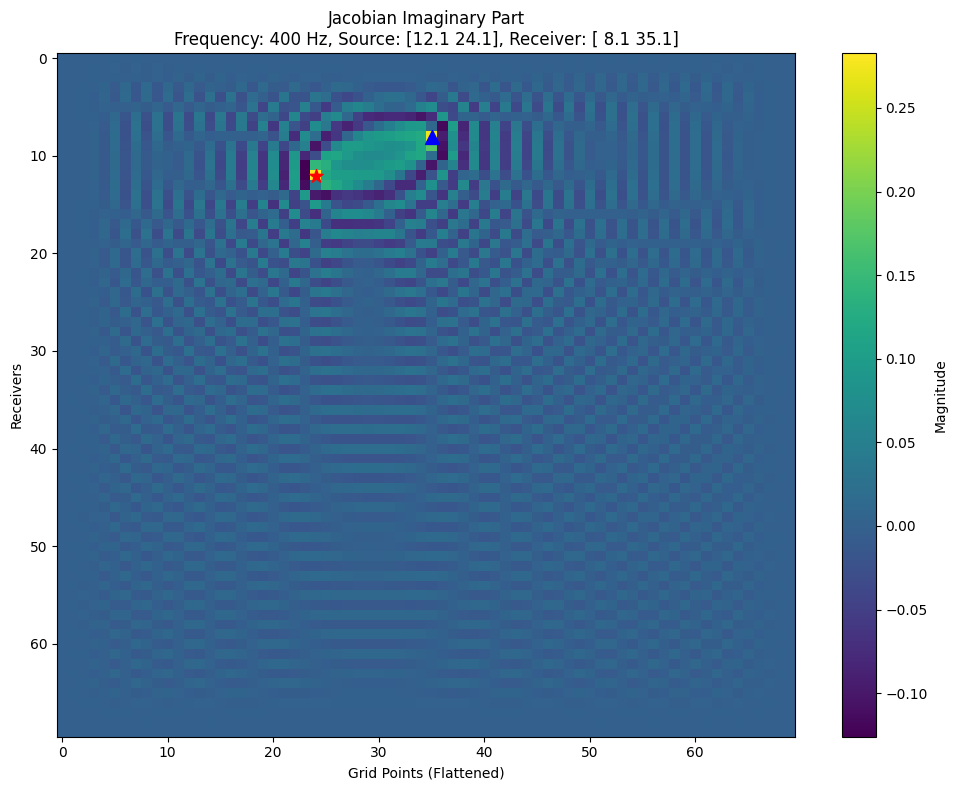

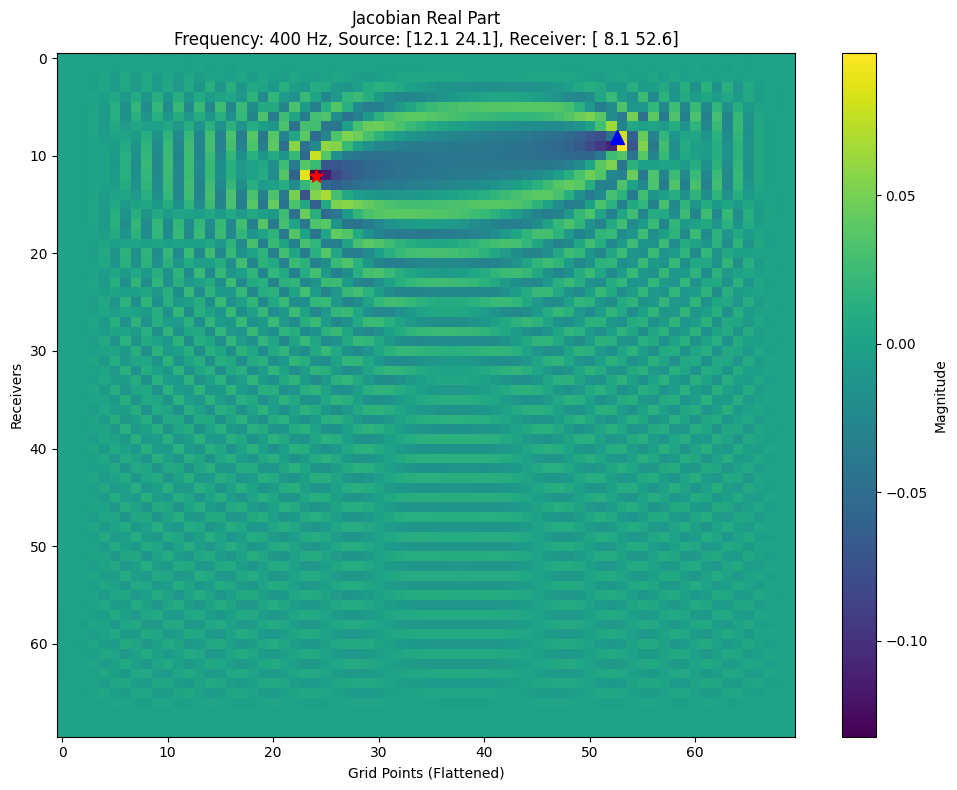

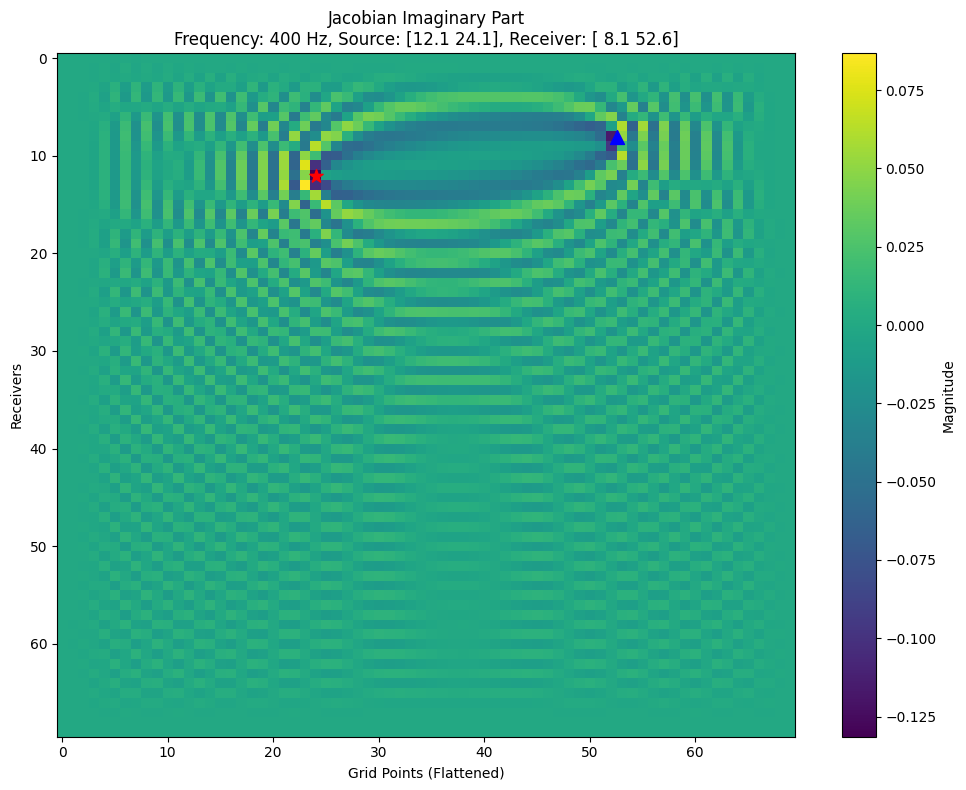

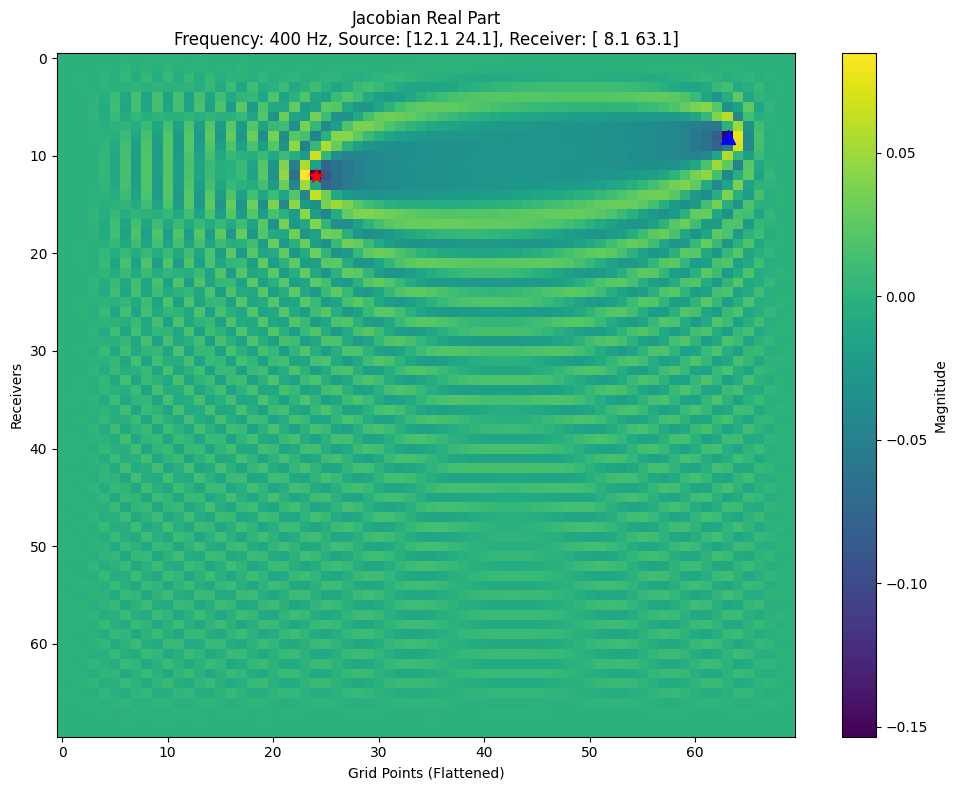

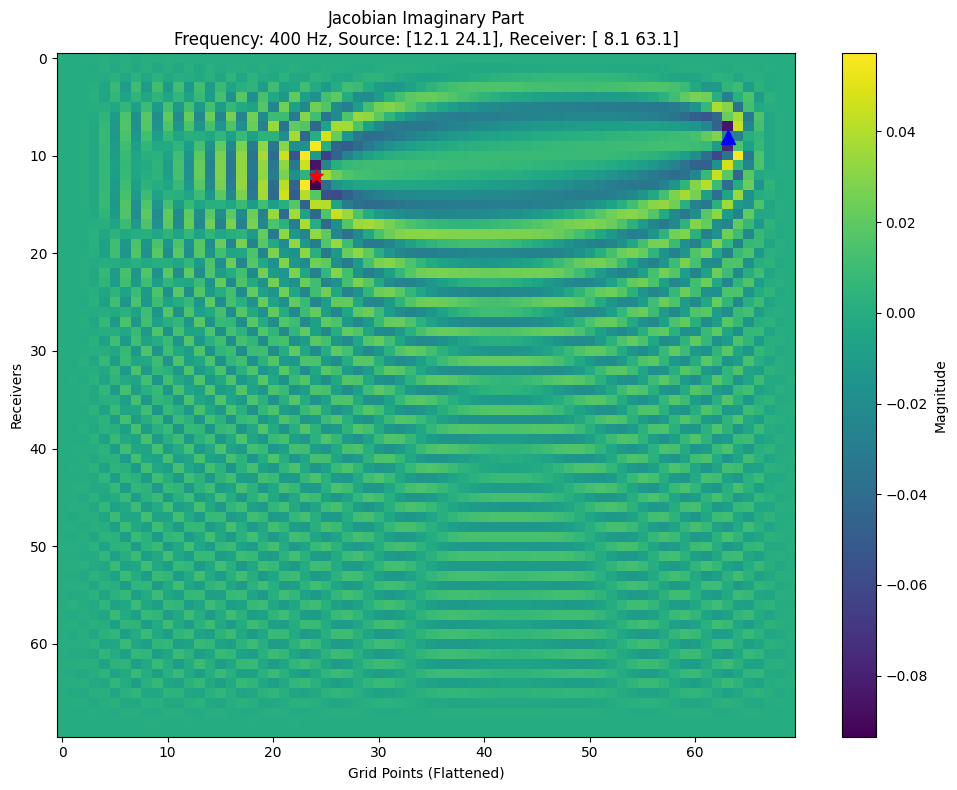

In [68]:
# Plot and display the real and imaginary parts separately
plot_jacobians_separately(jacobians,frequencies, src_coords_list, receiver_coords_list, save_path=None)

In [ ]:
# 